In [1]:
# 导出时隐藏代码
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di
_ = di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
CSS = """#notebook div.output_subarea {max-width:100%;}""" #changes output_subarea width to 100% (from 100% - 14ex)
_ = HTML('<style>{}</style>'.format(CSS))

In [2]:
import os
import re
import numpy as np
import pandas as pd
import random
import scipy
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cloudpickle as pickle
import copy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [3]:
BASE_DIR = './'
DATA_DIR = BASE_DIR+'Data/Discovery/'
ABUN_PATH = DATA_DIR+'NASH63_table_dn97_OTU.tsv'
META_PATH = DATA_DIR+'NASH_forward_63_map.txt'
TAX_PATH = DATA_DIR+'NASH63_dn97_OTU_taxonomy.tsv'
SPARCC_PATH = BASE_DIR+'Data/Discovery/SparCC/'
CAUSAL_PATH = BASE_DIR+'Data/Discovery/Causal inference/'
RESULT_PATH = BASE_DIR+'Result/Discovery/'
TEMP_PATH = BASE_DIR+'Temp/'
COVER_RATE = 0.5 # OTU 样本覆盖率
INTERACTION_P_THRESHOLD = 0.01 # 显著相互作用的p-value阈值
PRIOR_THRESHOLD = 0.0 # 相互作用先验概率阈值

# 1. 菌种（OTU）数据处理与差异分析

### 1.1 读取Read Counts (QIIME2，97%相似度聚类OTU)，转换为相对丰度

In [4]:
raw_count = pd.read_csv(ABUN_PATH, index_col=0, sep='\t', skiprows=[0]) # Read Counts
raw_abun = raw_count/raw_count.sum()*100. # 相对丰度
print('原始数据中一共'+str(raw_abun.shape[1])+'个样本，'+str(raw_abun.shape[0])+'个OTU')

原始数据中一共63个样本，5441个OTU


### 1.2 通过设置的样本覆盖度筛选OTU

In [5]:
sample_cover = (raw_abun>0).sum(1)/float(raw_abun.shape[1])
abun_df = raw_abun.loc[sample_cover >= COVER_RATE, :]
print('样本覆盖度高于'+str(COVER_RATE)+'的OTU一共'+str(abun_df.shape[0])+'个')
abun_df = abun_df.T
count_df = raw_count.loc[sample_cover >= COVER_RATE, :].T
abun_df.head()

样本覆盖度高于0.5的OTU一共97个


#OTU ID,2725fb5dd2001597d9a103735ec633f4fec723af,213246e0ef70d6a711664e7bd453dfe1c4e30106,543e9142bfd56e3312822277113e06cbb521aa91,b0f51adf671d76a5f07c3b5bc16ab4d5c4ff609b,2a069c745b4e3079b4be010d8e8d15866089a47c,595b5c69e0c0ab678b4b1457da6abbd3142afa3f,341e2fd8e931fa32697ef5a3cc97bbddddb81f32,759d3bce74029b0421b6b7829823329beec0cbda,7d217b5dac70526010aee823a23b9274e8fed212,0b814f25f0aac03c48bd8f719c6dba91f99df818,...,78d664d8199a1a5050c114fb3669304f3d9a8d4e,b1c85b23cb036d5783eb5cb420b42d5816b804f1,8adac8a13ae26336b44e1401350c58c3b7905593,4a750c3b25e9ba149a2323ba3b62ee0ca7940d83,dc838e370410fb0d4763470f21542ac3f052167a,795dbf8c019483a25ae9a8827a62a936185d84a0,cbf95306034ca33994a754185ac09707603d4a6e,568373ca075c2cf3245a60cc7d25de80c9a90f43,af877f3cca95c2c63622bf43466341fb27fd9f9c,a4c6b012d72033d40026c27a32be2901526531ce
NASH50,0.000000,0.000000,0.082457,0.020614,0.340136,0.000000,0.030921,0.000000,0.237065,0.020614,...,0.000000,0.000000,0.350443,0.020614,0.020614,0.061843,0.144300,0.010307,0.113379,0.000000
NASH63,0.000000,0.000000,0.000000,0.000000,1.162936,0.000000,0.137552,0.050019,0.175066,0.162561,...,0.000000,0.037514,0.212580,0.000000,0.000000,0.100038,0.037514,0.000000,0.125047,0.000000
NASH57,0.017641,0.000000,0.000000,0.000000,0.564523,0.070565,0.070565,0.000000,0.202876,0.052924,...,0.000000,0.008821,0.079386,0.000000,0.000000,0.000000,0.114669,9.843874,0.017641,0.000000
NASH60,0.129650,0.807819,0.000000,0.000000,11.588710,0.000000,0.000000,0.029919,0.199461,0.039892,...,0.009973,7.210532,0.079785,0.029919,0.069812,0.269273,0.089758,0.718061,0.059838,0.029919
NASH13,0.771439,0.053821,0.322928,0.197345,26.659490,2.134912,0.000000,0.125583,1.363473,0.466451,...,0.107643,0.000000,0.394690,0.161464,0.053821,10.010764,1.202009,0.017940,0.000000,0.017940


### 1.3 数据的样本注释信息

,Normal,Obese,NASH
#,16,25,22


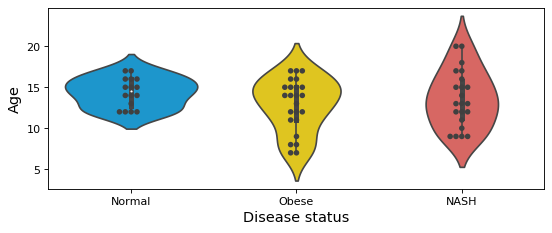

In [6]:
meta = pd.read_csv(META_PATH, index_col=0, sep='\t')
meta = meta.loc[abun_df.index, ['DiseaseStatus', 'age', 'sex', 'BMI', 'BMI_z_score','Ethnicity']]
DiseaseStatus = meta['DiseaseStatus']
res = pd.DataFrame([[(DiseaseStatus=='Normal').sum(), (DiseaseStatus=='Obese').sum(),
                     (DiseaseStatus=='NASH').sum()]], columns=['Normal', 'Obese', 'NASH'], index=['#'])
res
_ = plt.figure(1, (8, 3), dpi=80)
_ = sns.violinplot(x="DiseaseStatus", y="age", data=meta, palette=['#00a1e9', '#ffdc00','#ea5550'],
                  order=['Normal', 'Obese', 'NASH'])
_ = sns.swarmplot(x="DiseaseStatus", y="age", data=meta, color=".25",
                 order=['Normal', 'Obese', 'NASH'])
_ = plt.xlabel('Disease status', fontsize=13)
_ = plt.ylabel('Age', fontsize=13)
_ = plt.show()

不同状态的年龄分布较为均衡一致，可以进行后续分析

### 1.4 OTU物种注释信息

In [7]:
tax_df = pd.read_csv(TAX_PATH, index_col=0, sep='\t')
tax_df.head()

,Taxon,Confidence
Feature ID,,
00027332976e52cf30d532cbd5447a4d4c29fdd0,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,0.993246
001dd8365cf1ba6c4b492bff792c488461bdb919,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.988699
0029a7eca4986593dd6fa716ffd0a4121807fb9b,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.998840
0030aa3b36ed941fec713220841c8edafe0951a8,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,0.999988
00326beffa9417275f1eb1051b3fa90e218fd4ef,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.999819


In [10]:
tax_species = pd.read_csv(DATA_DIR+'NASH63_dn97_OTU_taxonomy_NCBI_reassign.csv', index_col=0)
tax_species.head()

,OTU_ID,Tax,Class,Family,NCBI_ID,NCBI_Tax,Species,Abb.
04f6d8267903b2cc853efc25678b5d11da252ba8,OTU30,D_0__Bacteria;D_1__Proteobacteria;D_2__Deltapr...,Desulfovibrionales,Desulfovibrionaceae,-,-,Bilophila(OTU30),Bilophila(OTU30)
055eb03b82092827561fa816d990711e65a10a2d,OTU24,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,Bacteroidales,Bacteroidaceae,NR_041461.1,Bacteroides coprophilus,Bacteroides coprophilus,B. coprophilus
06a157c47ae3d15ba27d3409e47b2d1bda1228d9,OTU34,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,Clostridiales,Family XI,-,-,Peptoniphilus lacrimalis,P. lacrimalis
0b814f25f0aac03c48bd8f719c6dba91f99df818,OTU9,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,Clostridiales,Lachnospiraceae,NR_028883.1,Dorea longicatena,Dorea longicatena,D. longicatena
0cfa2d530d8bb8deb60488dd1a5ae30b0783b626,OTU72,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,Bacteroidales,Bacteroidaceae,NR_148821.1,Bacteroides caecicola,Bacteroides caecicola(OTU72),B. caecicola(OTU72)


### 1.5 丰度差异菌种

In [12]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
def cal_RankSum(data, disease, ds1, ds2, tax, alpha = 0.01):
    res = []
    for i in data.columns:
        value1 = data.loc[disease==ds1, i]
        value2 = data.loc[disease==ds2, i]
        score, pvalue = ranksums(value1, value2)
        fold_change = value2.mean()/float(value1.mean()) if value1.mean() else np.nan
        res.append([i, tax.loc[i, 'Class'], tax.loc[i, 'Family'],tax.loc[i, 'Species'], value1.mean(), value2.mean(), fold_change, score, pvalue])
    res = pd.DataFrame(res, columns=['OTU', 'Class', 'Family', 'Species', ds1, ds2, 'FC', 'RankSum', 'p-value'])
    reject, fdr, _, _ = multipletests(list(res['p-value']), alpha=alpha, method='fdr_bh')
    res['FDR'] = fdr
    res = res.sort_values(by='FDR', ascending=True)
    res.index = range(len(res.index))
    return res

print('### NASH vs Normal:')
NASH_vs_Normal = cal_RankSum(abun_df, DiseaseStatus, 'Normal', 'NASH', tax_species, alpha = 0.01)
NASH_vs_Normal.index = NASH_vs_Normal['OTU']
temp = NASH_vs_Normal.copy()
temp.index = range(len(temp.index))
temp.head(10)

print('### Obese vs Normal:')
Obese_vs_Normal = cal_RankSum(abun_df, DiseaseStatus, 'Normal', 'Obese', tax_species, alpha = 0.01)
Obese_vs_Normal.index = Obese_vs_Normal['OTU']
temp = Obese_vs_Normal.copy()
temp.index = range(len(temp.index))
temp.head(10)

print('### NASH vs Obese:')
NASH_vs_Obese = cal_RankSum(abun_df, DiseaseStatus, 'Obese', 'NASH', tax_species, alpha = 0.01)
NASH_vs_Obese.index = NASH_vs_Obese['OTU']
temp = NASH_vs_Obese.copy()
temp.index = range(len(temp.index))
temp.head(10)

### NASH vs Normal:


,OTU,Class,Family,Species,Normal,NASH,FC,RankSum,p-value,FDR
0,4055b3f1e3e0a8f04d0a83f7de0e7ca9fcdc0222,Clostridiales,Family XI,Peptoniphilus ivorii,0.147343,1.076928,7.308984,-4.641802,0.000003,0.000168
1,93a203cd147eaca4fefa76a477e453dd6a16f551,Clostridiales,Family XI,Anaerococcus octavius,0.010438,1.548501,148.345838,-4.774848,0.000002,0.000168
2,a4c6b012d72033d40026c27a32be2901526531ce,Clostridiales,Ruminococcaceae,Ruminiclostridium(OTU96),0.558847,0.050694,0.090711,3.843531,0.000121,0.002353
3,36b71e0fa60b370e95082d0cee5ba3ed92ea4f14,Clostridiales,Family XI,Finegoldia magna,0.024066,1.830496,76.060776,-3.843531,0.000121,0.002353
4,c17c40fbf5843a9a0c17aa02432b3902ffe021a4,Clostridiales,Family XI,Ezakiella peruensis,0.188914,0.757100,4.007636,-3.843531,0.000121,0.002353
5,b7958ee8f163b8c7f8efcd7f093f897421c2eeeb,Clostridiales,Lachnospiraceae,Blautia hydrogenotrophica,1.025322,0.194095,0.189302,3.784399,0.000154,0.002491
6,6e7e6fb1a2a243f338a53dddf99816665d92bd49,Clostridiales,Lachnospiraceae,Eubacterium oxidoreducens,0.824847,0.155155,0.188102,3.636571,0.000276,0.002680
7,6d16c8dfa0d7dce3f6e27a904b61a21c2be8d0f5,Clostridiales,Family XI,Peptoniphilus olsenii,0.083862,0.705046,8.407242,-3.725268,0.000195,0.002680
8,7c2e0be05c81e92be893416502901cc796a11a97,Clostridiales,Lachnospiraceae,Eubacterium rectale(OTU52),0.501948,0.081236,0.161841,3.651354,0.000261,0.002680
9,d77ce8b9e5a334c7e4103f6f21bf217540134ced,Clostridiales,Lachnospiraceae,Fusicatenibacter saccharivorans,1.208493,0.284345,0.235289,3.666137,0.000246,0.002680


### Obese vs Normal:


,OTU,Class,Family,Species,Normal,Obese,FC,RankSum,p-value,FDR
0,36b71e0fa60b370e95082d0cee5ba3ed92ea4f14,Clostridiales,Family XI,Finegoldia magna,0.024066,2.108509,87.612774,-4.089097,0.000043,0.004201
1,4055b3f1e3e0a8f04d0a83f7de0e7ca9fcdc0222,Clostridiales,Family XI,Peptoniphilus ivorii,0.147343,1.630741,11.067645,-3.594664,0.000325,0.007877
2,3ba90965ce76880f6bbcddc96b6ab309ac932ee1,Clostridiales,Lachnospiraceae,Blautia hansenii,0.241392,0.035488,0.147014,3.621390,0.000293,0.007877
3,93a203cd147eaca4fefa76a477e453dd6a16f551,Clostridiales,Family XI,Anaerococcus octavius,0.010438,0.943052,90.344024,-3.728294,0.000193,0.007877
4,b7958ee8f163b8c7f8efcd7f093f897421c2eeeb,Clostridiales,Lachnospiraceae,Blautia hydrogenotrophica,1.025322,0.205841,0.200758,3.527848,0.000419,0.008128
5,d77ce8b9e5a334c7e4103f6f21bf217540134ced,Clostridiales,Lachnospiraceae,Fusicatenibacter saccharivorans,1.208493,0.381556,0.315729,3.340766,0.000835,0.011577
6,3a21d49f9431e24145b80c43adc46af78fd5f00f,Campylobacterales,Campylobacteraceae,Campylobacter pinnipediorum,0.011937,1.457035,122.064548,-3.340766,0.000835,0.011577
7,6e7e6fb1a2a243f338a53dddf99816665d92bd49,Clostridiales,Lachnospiraceae,Eubacterium oxidoreducens,0.824847,0.228980,0.277602,3.287313,0.001011,0.012264
8,568373ca075c2cf3245a60cc7d25de80c9a90f43,Clostridiales,Family XI,Ezakiella(OTU94),2.514465,5.171592,2.056736,-3.180409,0.001471,0.012969
9,7ee6bdbeafe5f04b4d10a682bab889c7852be4cd,Bacteroidales,Porphyromonadaceae,Porphyromonas sp. 2007b,0.024521,0.947344,38.633484,-3.180409,0.001471,0.012969


### NASH vs Obese:


,OTU,Class,Family,Species,Obese,NASH,FC,RankSum,p-value,FDR
0,7f50d4d8d87d26b57bb3da8edfb1b5d72f05e75c,Clostridiales,Lachnospiraceae,Lachnoclostridium pacaense,0.048881,0.134305,2.747614,-1.684286,0.092126,0.772438
1,af877f3cca95c2c63622bf43466341fb27fd9f9c,Bacteroidales,Marinifilaceae,Odoribacter denticanis,0.084439,0.207908,2.462225,-1.524385,0.127413,0.772438
2,c84919371da9c309c2b7a50ab6ed836c0c9555e6,Selenomonadales,Veillonellaceae,Dialister pneumosintes,0.582842,1.211738,2.079016,-1.662966,0.096319,0.772438
3,7c8124a599ef55c3aca8d4c1edee81189d249762,Clostridiales,Ruminococcaceae,Ruminococcus lactaris(OTU43),0.376316,0.066171,0.175840,2.046727,0.040685,0.772438
4,e5db91f58295e8e2597c1853ff383348b92c2d10,Clostridiales,Lachnospiraceae,Bacteroides xylanolyticus,0.135434,0.062151,0.458902,1.567025,0.117109,0.772438
5,dc838e370410fb0d4763470f21542ac3f052167a,Clostridiales,Ruminococcaceae,Ruminococcaceae(OTU91),0.083416,0.049727,0.596136,1.535045,0.124773,0.772438
6,69f5addfb12c83bce0beaa7a738668e8a772480e,Bacteroidales,Rikenellaceae,Alistipes indistinctus(OTU20),0.153642,0.059767,0.388999,1.705606,0.088082,0.772438
7,6c4a13cb8c2989b4ddf90ce4827e1a46ec08fdbd,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium magnum,1.000405,0.295275,0.295156,1.556365,0.119621,0.772438
8,b1c85b23cb036d5783eb5cb420b42d5816b804f1,Enterobacteriales,Enterobacteriaceae,Escherichia-Shigella(OTU88),0.536001,4.909103,9.158755,-2.281248,0.022534,0.772438
9,5a61829814af31711bd597f814142ea04f651806,Lactobacillales,Leuconostocaceae,Leuconostoc fallax,0.034350,0.100538,2.926887,-1.662966,0.096319,0.772438


* Clostridiales(梭菌目)是主要出现差异表达的菌种Class，该Class中包括了Lachnospiraceae(毛螺菌科)，Family XI和Ruminococcaceae(瘤胃菌科)等差异的Family；
* Obese和NASH相较于Normal差异较为明显(FDR<0.01)，而Obese和NASH之间差异较小（FDR>0.7）;

In [25]:
NASH_vs_Normal.to_csv(RESULT_PATH+'NASH_vs_Normal_DE.csv')
Obese_vs_Normal.to_csv(RESULT_PATH+'Obese_vs_Normal_DE.csv')
NASH_vs_Obese.to_csv(RESULT_PATH+'NASH_vs_Obese_DE.csv')

### 1.6 差异菌种变化情况-bar图（选取NASH vs Normal中 FDR<0.01的菌种进行分析）

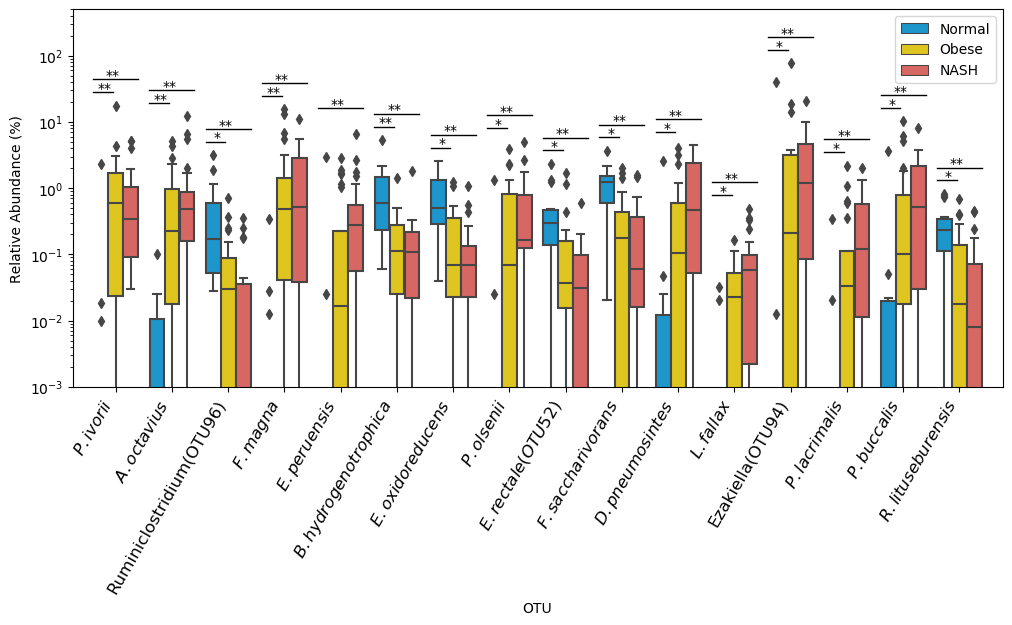

In [15]:
DEOTU = NASH_vs_Normal.loc[NASH_vs_Normal['FDR']<0.01, 'OTU']
res_plot = []
for otu in DEOTU:
    for d in ['Normal', 'Obese', 'NASH']:
        for i in abun_df.loc[DiseaseStatus==d, otu]:
            res_plot.append([otu, tax_df.loc[otu, 'Taxon'], d, i])
res_plot = pd.DataFrame(res_plot, columns=['OTU', 'Taxon', 'State', 'Abundance'])
_ = plt.figure(figsize=(12, 5), dpi=100)
p = sns.boxplot(x="OTU", y="Abundance", hue="State", data=res_plot, palette=['#00a1e9', '#ffdc00','#ea5550'])
######
import matplotlib.lines as mlines
i = 0
for otu in DEOTU:
    max_value = res_plot.loc[res_plot['OTU']==otu, 'Abundance'].max()
    if Obese_vs_Normal.loc[otu, 'FDR']<=0.05:
        x, y = np.array([[i-0.4, i-0.05], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.2, max_value*1.6, '**' if Obese_vs_Normal.loc[otu, 'FDR']<=0.01 else '*',
                     ha="center", size=10)
        
    if NASH_vs_Obese.loc[otu, 'FDR']<=0.05:
        x, y = np.array([[i+0.05, i+0.4], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i+0.2, max_value*1.6, '**' if NASH_vs_Obese.loc[otu, 'FDR']<=0.01 else '*',
                     ha="center", size=10)
        
    if NASH_vs_Normal.loc[otu, 'FDR']<=0.05:
        x, y = np.array([[i-0.4, i+0.4], [max_value*2.5, max_value*2.5]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.05, max_value*2.5, '**' if NASH_vs_Normal.loc[otu, 'FDR']<=0.01 else '*',
                     ha="center", size=10)
    i += 1  
#######   
_ = plt.ylim([10**(-3), 500])
_ = plt.semilogy()
_ = plt.xticks(range(len(DEOTU)), 
               ['$'+tax_species.loc[otu, 'Abb.']+'$' if '.' in tax_species.loc[otu, 'Abb.'] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU],
               rotation=60, ha='right', fontsize=12)
_ = plt.legend(loc='upper right')
_ = plt.ylabel('Relative Abundance (%)')
_ = plt.show()

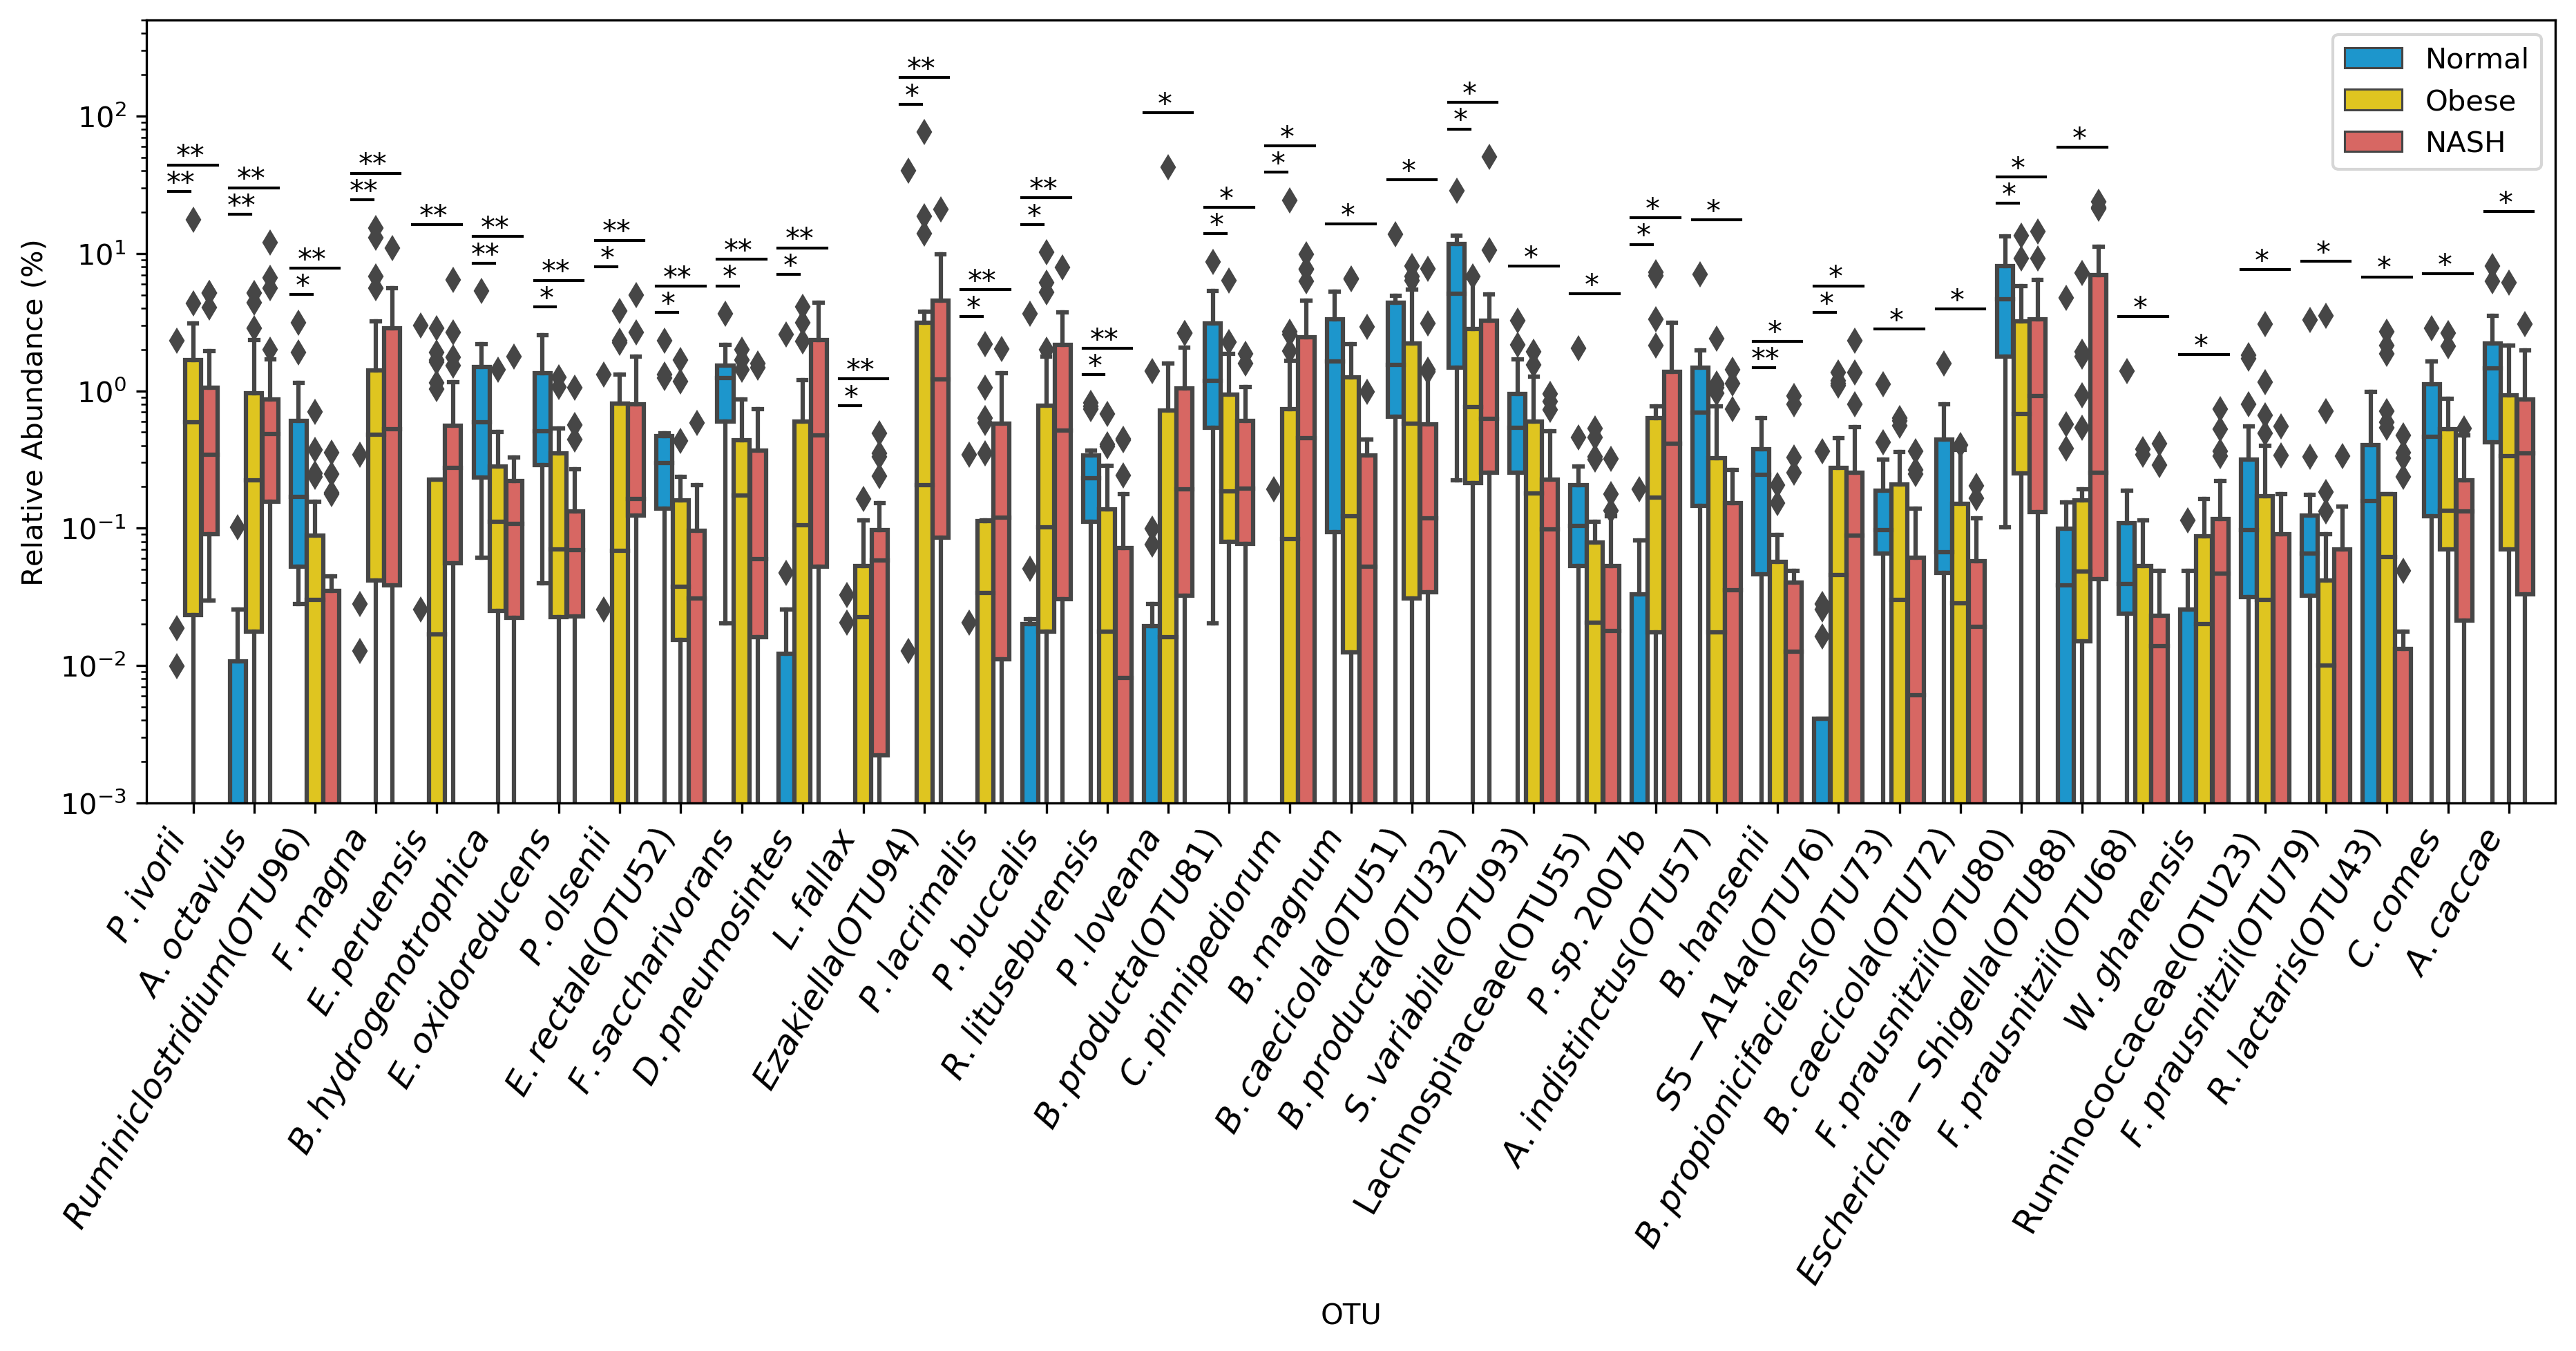

In [205]:
DEOTU = NASH_vs_Normal.loc[NASH_vs_Normal['FDR']<0.05, 'OTU']
res_plot = []
for otu in DEOTU:
    for d in ['Normal', 'Obese', 'NASH']:
        for i in abun_df.loc[DiseaseStatus==d, otu]:
            res_plot.append([otu, tax_df.loc[otu, 'Taxon'], d, i])
res_plot = pd.DataFrame(res_plot, columns=['OTU', 'Taxon', 'State', 'Abundance'])
_ = plt.figure(figsize=(15, 5), dpi=300)
p = sns.boxplot(x="OTU", y="Abundance", hue="State", data=res_plot, palette=['#00a1e9', '#ffdc00','#ea5550'])
######
import matplotlib.lines as mlines
i = 0
for otu in DEOTU:
    max_value = res_plot.loc[res_plot['OTU']==otu, 'Abundance'].max()
    if Obese_vs_Normal.loc[otu, 'FDR']<=0.05:
        x, y = np.array([[i-0.4, i-0.05], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.2, max_value*1.6, '**' if Obese_vs_Normal.loc[otu, 'FDR']<=0.01 else '*',
                     ha="center", size=10)
        
    if NASH_vs_Obese.loc[otu, 'FDR']<=0.05:
        x, y = np.array([[i+0.05, i+0.4], [max_value*1.6, max_value*1.6]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i+0.2, max_value*1.6, '**' if NASH_vs_Obese.loc[otu, 'FDR']<=0.01 else '*',
                     ha="center", size=10)
        
    if NASH_vs_Normal.loc[otu, 'FDR']<=0.05:
        x, y = np.array([[i-0.4, i+0.4], [max_value*2.5, max_value*2.5]])
        l = mlines.Line2D(x, y, lw=1., c='k')
        _ = p.add_line(l)
        _ = plt.text(i-0.05, max_value*2.5, '**' if NASH_vs_Normal.loc[otu, 'FDR']<=0.01 else '*',
                     ha="center", size=10)
    i += 1  
#######   
_ = plt.ylim([10**(-3), 500])
_ = plt.semilogy()

I = dict([[tax_species.loc[otu, 'Abb.'], ('.' in tax_species.loc[otu, 'Abb.'])] for otu in DEOTU])
I['Ezakiella(OTU94)'] = True
I['Ruminiclostridium(OTU96)'] = True
I['S5-A14a(OTU76)'] = True
I['Escherichia-Shigella(OTU88)'] = True

_ = plt.xticks(range(len(DEOTU)), 
               ['$'+tax_species.loc[otu, 'Abb.']+'$' if I[tax_species.loc[otu, 'Abb.']] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU],
               rotation=60, ha='right', fontsize=12)
_ = plt.legend(loc='upper right')
_ = plt.ylabel('Relative Abundance (%)')
_ = plt.show()

* NASH对Normal显著差异的16个菌种(FDR<0.01)，在Obese中也基本出现显著差异（FDR<0.05）; 
* 菌种丰度在 Normal - Obese - NASH 疾病发展过程中呈现阶梯式的变化的趋势，表明NASH比Obese菌种变化更加强烈；
* Lachnospiraceae和Ruminococcaceae两个Family菌种在疾病中都统一显著下调，而Family XI中菌种统一显著上调；

### 1.7 差异菌种变化情况-热图（选取NASH vs Normal中 FDR<0.01的菌种进行分析）

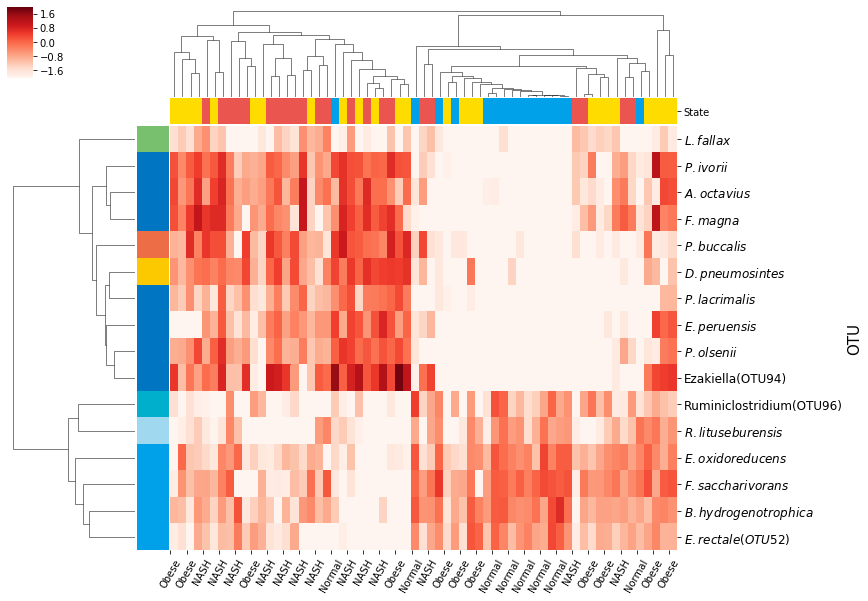

In [53]:
DEOTU = NASH_vs_Normal.loc[NASH_vs_Normal['FDR']<0.01, 'OTU']
hearmap_data = abun_df.loc[:, DEOTU].T
#hearmap_data
color = {'Normal':'#00a1e9', 'Obese':'#ffdc00', 'NASH':'#ea5550',
        'Family XI':'#0075c2', 'Ruminococcaceae':'#00afcc', 'Lachnospiraceae':'#00a1e9', 'Peptostreptococcaceae':'#a0d8ef', # Clostridiales
         'Veillonellaceae':'#fcc800', # Selenomonadales
         'Prevotellaceae':'#ed6d46', # Bacteroidales
         'Leuconostocaceae':'#79c06e', # Lactobacillales
        }
col_colors = pd.Series(data=[color[meta.loc[i, 'DiseaseStatus']] for i in hearmap_data.columns],
                       index=hearmap_data.columns, name='State')

index = ['$'+tax_species.loc[otu, 'Abb.']+'$' if '.' in tax_species.loc[otu, 'Abb.'] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU]
row_colors = [color[tax_species.loc[otu, 'Family']] for otu in DEOTU]
columns = [meta.loc[i, 'DiseaseStatus'] for i in hearmap_data.columns]
hearmap_data = pd.DataFrame(np.log10(hearmap_data+10**(-10)), index=hearmap_data.index,
                            columns=hearmap_data.columns)
g = sns.clustermap(hearmap_data, cmap="Reds", vmin=-2, vmax=2, row_cluster=True, col_cluster=True,
                   col_colors=col_colors, row_colors=row_colors, figsize=(12, 10), metric='braycurtis')

_ = g.ax_heatmap.axes.set_ylim([16,0])
#_ = g.ax_heatmap.axes.set_xticks([])
_ = g.ax_heatmap.axes.set_xticks(range(len(columns))[::2])
_ = g.ax_heatmap.axes.set_xticklabels(np.array(columns)[g.dendrogram_col.reordered_ind][::2], fontsize=10, rotation=60)
_ = g.ax_heatmap.axes.set_yticklabels(np.array(index)[g.dendrogram_row.reordered_ind], fontsize=12)
_ = g.ax_heatmap.axes.set_ylabel('OTU', fontsize=15)

39

(-9.965784284662087, 6.25362048005296)

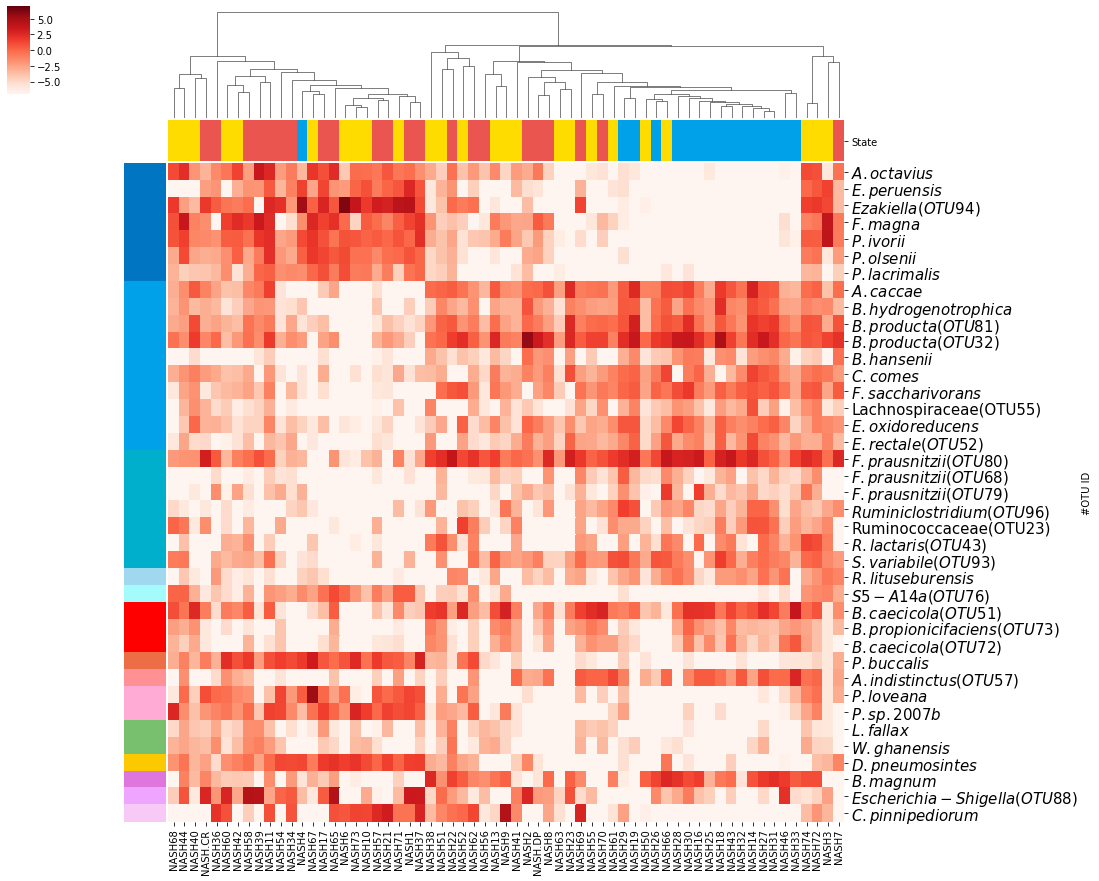

In [201]:
DEOTU = NASH_vs_Normal.loc[NASH_vs_Normal['FDR']<0.05, 'OTU']
heatmap_data = abun_df.loc[:, DEOTU].T
new_index = sorted([(i, tax_species.loc[i, 'Tax']) for i in heatmap_data.index], key=lambda x:x[1])
heatmap_data = heatmap_data.loc[[i[0] for i in new_index], :]

index_sort = ['Family XI', 'Lachnospiraceae', 'Ruminococcaceae', 'Peptostreptococcaceae', 'Family XIII', 
            'Bacteroidaceae', 'Prevotellaceae', 'Rikenellaceae', 'Marinifilaceae', 'Porphyromonadaceae', 
            'Tannerellaceae', 
            'Leuconostocaceae', 'Streptococcaceae', 
            'Veillonellaceae', 
            'Burkholderiaceae', 'Bifidobacteriaceae', 'Enterobacteriaceae', 'Campylobacteraceae', 'Desulfovibrionaceae']
new_index = []
for i in index_sort:
    for j in heatmap_data.index:
        if tax_species.loc[j, 'Family'] == i:
            new_index.append(j)

new_columns = []
for i in ['Normal', 'Obese', 'NASH']:
    for j in heatmap_data.columns:
        if meta.loc[j, 'DiseaseStatus'] == i:
            new_columns.append(j)

heatmap_data = heatmap_data.loc[new_index, new_columns]

#hearmap_data
color = {'Normal':'#00a1e9', 'Obese':'#ffdc00', 'NASH':'#ea5550',
        'Family XI':'#0075c2', 'Ruminococcaceae':'#00afcc', 'Lachnospiraceae':'#00a1e9', 'Peptostreptococcaceae':'#a0d8ef', # Clostridiales
         'Veillonellaceae':'#fcc800', # Selenomonadales
         'Prevotellaceae':'#ed6d46', # Bacteroidales
         'Leuconostocaceae':'#79c06e', # Lactobacillales
         # <0.05
         'Porphyromonadaceae':'#ffabd5', # Bacteroidales
         'Campylobacteraceae':'#f6c9f6', # Other Campylobacterales
         'Bifidobacteriaceae':'#de76de', # Other
         'Bacteroidaceae':'#ff0000', # Bacteroidales
         'Rikenellaceae':'#ff9093', # Bacteroidales
         'Family XIII':'#a4fbfb', #
         'Enterobacteriaceae':'#eda5ff',
        }
col_colors = pd.Series(data=[color[meta.loc[i, 'DiseaseStatus']] for i in heatmap_data.columns],
                       index=heatmap_data.columns, name='State')


I = dict([[tax_species.loc[otu, 'Abb.'], ('.' in tax_species.loc[otu, 'Abb.'])] for otu in heatmap_data.index])
I['Ezakiella(OTU94)'] = True
I['Ruminiclostridium(OTU96)'] = True
I['S5-A14a(OTU76)'] = True
I['Escherichia-Shigella(OTU88)'] = True
#heatmap_data.shape[0]
#', '.join([tax_species.loc[otu, 'Species'] for otu in heatmap_data.index])

index = ['$'+tax_species.loc[otu, 'Abb.']+'$' if I[tax_species.loc[otu, 'Abb.']] else tax_species.loc[otu, 'Abb.'] for otu in heatmap_data.index]
row_colors = [color[tax_species.loc[otu, 'Family']] for otu in heatmap_data.index]
columns = [meta.loc[i, 'DiseaseStatus'] for i in heatmap_data.columns]

heatmap_data = pd.DataFrame(np.log2(heatmap_data+10**(-3)), index=heatmap_data.index,
                            columns=heatmap_data.columns)

#for i in range(heatmap_data.shape[0]):
#    heatmap_data.iloc[i, :] = (heatmap_data.iloc[i, :]-heatmap_data.mean(1)[i])/heatmap_data.std(1)[i]

heatmap_data.min().min(), heatmap_data.max().max()

g = sns.clustermap(heatmap_data, cmap="Reds", vmin=-7, vmax=7, figsize=(15, 15), 
                   col_colors=col_colors, row_colors=row_colors, 
                   row_cluster=None, col_cluster=True, metric='correlation')

_ = g.ax_heatmap.axes.set_ylim([39,0])
#_ = g.ax_heatmap.axes.set_xticks([])
#_ = g.ax_heatmap.axes.set_xticks(range(len(columns))[::2])
#_ = g.ax_heatmap.axes.set_xticklabels(np.array(columns)[g.dendrogram_col.reordered_ind][::2], fontsize=10, rotation=60)
_ = g.ax_heatmap.axes.set_yticklabels(index, fontsize=15)
#_ = g.ax_heatmap.axes.set_ylabel('OTU', fontsize=15)

* 在显著差异菌种中，Normal(蓝色)，NASH(红色)呈现明显不同，Obese(绿色)的丰度变化介于两者之间；
* 部分Obese病人更像Normal的菌种丰度；另一部分则更像NASH；
* Lachnospiraceae和Ruminococcaceae两个Family菌种在疾病中都统一显著下调，而Family XI中菌种统一显著上调；

### 1.8 单OTU疾病状态分类模型（选取NASH vs Normal中 FDR<0.01的菌种进行分析）

4055b3f1e3e0a8f04d0a83f7de0e7ca9fcdc0222 Family XI 0.83625 0.9460227272727273 0.5072727272727273
93a203cd147eaca4fefa76a477e453dd6a16f551 Family XI 0.8487500000000001 0.9588068181818181 0.5936363636363636
a4c6b012d72033d40026c27a32be2901526531ce Ruminococcaceae 0.775 0.8693181818181818 0.6127272727272727
36b71e0fa60b370e95082d0cee5ba3ed92ea4f14 Family XI 0.8825 0.8693181818181819 0.5127272727272727
c17c40fbf5843a9a0c17aa02432b3902ffe021a4 Family XI 0.6925 0.8693181818181819 0.6709090909090909
b7958ee8f163b8c7f8efcd7f093f897421c2eeeb Lachnospiraceae 0.83 0.8636363636363638 0.5318181818181819
6e7e6fb1a2a243f338a53dddf99816665d92bd49 Lachnospiraceae 0.8075 0.8494318181818182 0.5409090909090909
6d16c8dfa0d7dce3f6e27a904b61a21c2be8d0f5 Family XI 0.7775000000000001 0.8579545454545455 0.5818181818181819
7c2e0be05c81e92be893416502901cc796a11a97 Lachnospiraceae 0.78125 0.8508522727272727 0.5827272727272726
d77ce8b9e5a334c7e4103f6f21bf217540134ced Lachnospiraceae 0.8125 0.8522727272727273 0.5409

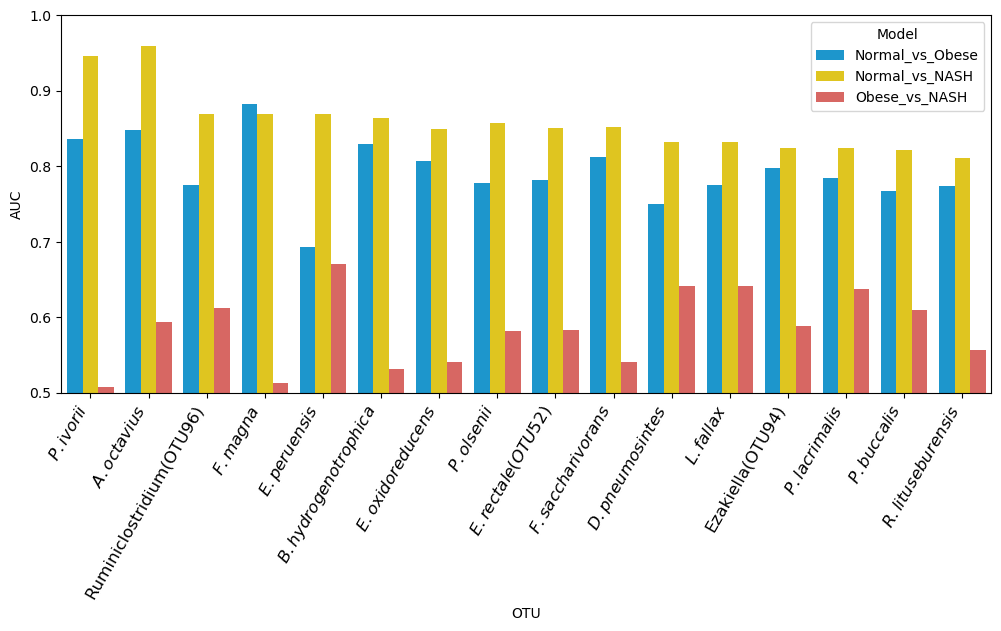

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
DEOTU = NASH_vs_Normal.loc[NASH_vs_Normal['FDR']<0.01, 'OTU']
dieases = DiseaseStatus
res = []
for otu in DEOTU:
    # Normal vs Obese
    X = abun_df.loc[dieases!='NASH', otu]
    y = (dieases[dieases!='NASH']=='Obese')+0
    auc1 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'].split('D_5__')[1], 'Normal_vs_Obese', auc1])
    # Normal vs NASH
    X = abun_df.loc[dieases!='Obese', otu]
    y = (dieases[dieases!='Obese']=='NASH')+0
    auc2 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'].split('D_5__')[1], 'Normal_vs_NASH', auc2])
    # Obese vs NASH
    X = abun_df.loc[dieases!='Normal', otu]
    y = (dieases[dieases!='Normal']=='NASH')+0
    auc3 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'].split('D_5__')[1], 'Obese_vs_NASH', auc3])
    print(otu, tax_species.loc[otu, 'Family'], auc1, auc2, auc3)
res = pd.DataFrame(res, columns=['OTU', 'Tax', 'Model', 'AUC'])

_ = plt.figure(figsize=(12, 5), dpi=100)
_ = sns.barplot(x="OTU", y="AUC", hue="Model", data=res, palette=['#00a1e9', '#ffdc00','#ea5550'])
_ = plt.ylim((0.5, 1))
_ = plt.xticks(range(len(DEOTU)), 
               ['$'+tax_species.loc[otu, 'Abb.']+'$' if '.' in tax_species.loc[otu, 'Abb.'] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU]
               , rotation=60, ha='right', fontsize=12)

4055b3f1e3e0a8f04d0a83f7de0e7ca9fcdc0222 Family XI 0.83625 0.9460227272727273 0.5072727272727273
93a203cd147eaca4fefa76a477e453dd6a16f551 Family XI 0.8487500000000001 0.9588068181818181 0.5936363636363636
a4c6b012d72033d40026c27a32be2901526531ce Ruminococcaceae 0.775 0.8693181818181818 0.6127272727272727
36b71e0fa60b370e95082d0cee5ba3ed92ea4f14 Family XI 0.8825 0.8693181818181819 0.5127272727272727
c17c40fbf5843a9a0c17aa02432b3902ffe021a4 Family XI 0.6925 0.8693181818181819 0.6709090909090909
b7958ee8f163b8c7f8efcd7f093f897421c2eeeb Lachnospiraceae 0.83 0.8636363636363638 0.5318181818181819
6e7e6fb1a2a243f338a53dddf99816665d92bd49 Lachnospiraceae 0.8075 0.8494318181818182 0.5409090909090909
6d16c8dfa0d7dce3f6e27a904b61a21c2be8d0f5 Family XI 0.7775000000000001 0.8579545454545455 0.5818181818181819
7c2e0be05c81e92be893416502901cc796a11a97 Lachnospiraceae 0.78125 0.8508522727272727 0.5827272727272726
d77ce8b9e5a334c7e4103f6f21bf217540134ced Lachnospiraceae 0.8125 0.8522727272727273 0.5409

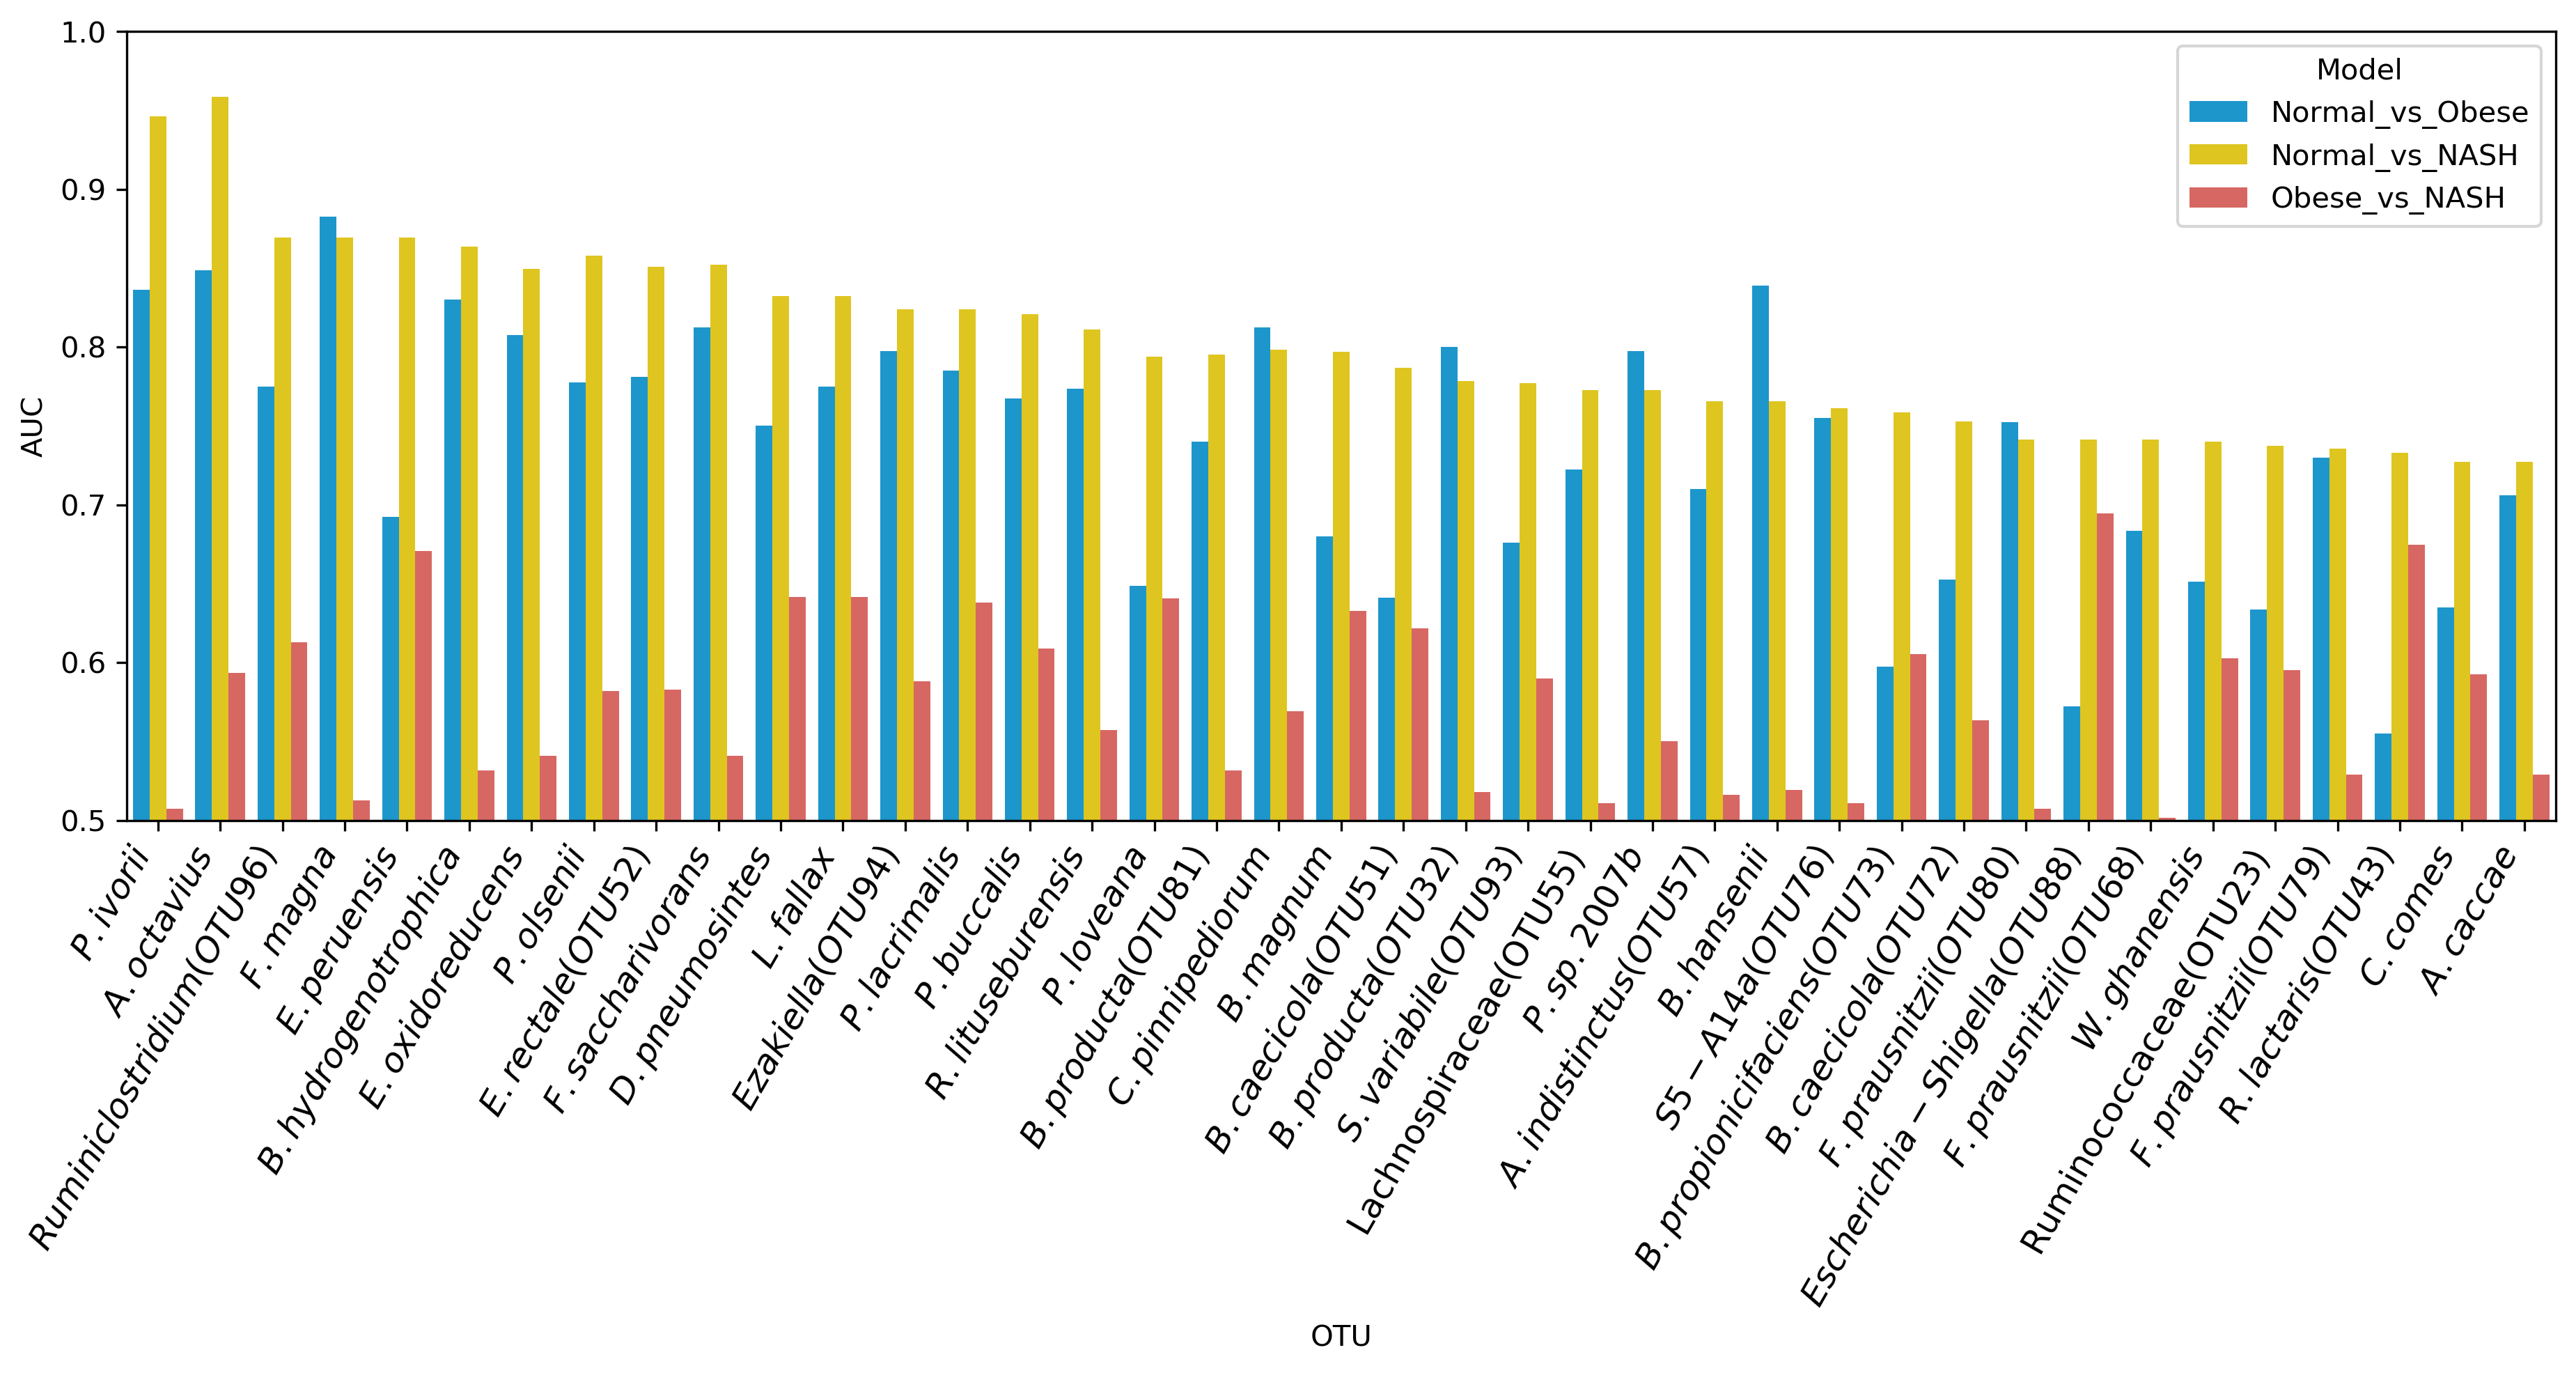

In [208]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
DEOTU = NASH_vs_Normal.loc[NASH_vs_Normal['FDR']<0.05, 'OTU']
dieases = DiseaseStatus
res = []
for otu in DEOTU:
    # Normal vs Obese
    X = abun_df.loc[dieases!='NASH', otu]
    y = (dieases[dieases!='NASH']=='Obese')+0
    auc1 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'].split('D_5__')[1], 'Normal_vs_Obese', auc1])
    # Normal vs NASH
    X = abun_df.loc[dieases!='Obese', otu]
    y = (dieases[dieases!='Obese']=='NASH')+0
    auc2 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'].split('D_5__')[1], 'Normal_vs_NASH', auc2])
    # Obese vs NASH
    X = abun_df.loc[dieases!='Normal', otu]
    y = (dieases[dieases!='Normal']=='NASH')+0
    auc3 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    res.append([otu, tax_df.loc[otu, 'Taxon'].split('D_5__')[1], 'Obese_vs_NASH', auc3])
    print(otu, tax_species.loc[otu, 'Family'], auc1, auc2, auc3)
res = pd.DataFrame(res, columns=['OTU', 'Tax', 'Model', 'AUC'])

_ = plt.figure(figsize=(15, 5), dpi=300)
_ = sns.barplot(x="OTU", y="AUC", hue="Model", data=res, palette=['#00a1e9', '#ffdc00','#ea5550'])
_ = plt.ylim((0.5, 1))
I = dict([[tax_species.loc[otu, 'Abb.'], ('.' in tax_species.loc[otu, 'Abb.'])] for otu in heatmap_data.index])
I['Ezakiella(OTU94)'] = True
I['Ruminiclostridium(OTU96)'] = True
I['S5-A14a(OTU76)'] = True
I['Escherichia-Shigella(OTU88)'] = True
_ = plt.xticks(range(len(DEOTU)), 
               ['$'+tax_species.loc[otu, 'Abb.']+'$' if I[tax_species.loc[otu, 'Abb.']] else tax_species.loc[otu, 'Abb.'] for otu in DEOTU]
               , rotation=60, ha='right', fontsize=12)

In [30]:
keystones = ['f6944e5be5cca661767014ab95867c4dc3848235', 
             '9075bd7b4542aad1faf685d8960946088cca0810', 
             'c84919371da9c309c2b7a50ab6ed836c0c9555e6']
for otu in keystones:
    # Normal vs Obese
    X = abun_df.loc[dieases!='NASH', otu]
    y = (dieases[dieases!='NASH']=='Obese')+0
    auc1 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    # Normal vs NASH
    X = abun_df.loc[dieases!='Obese', otu]
    y = (dieases[dieases!='Obese']=='NASH')+0
    auc2 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    # Obese vs NASH
    X = abun_df.loc[dieases!='Normal', otu]
    y = (dieases[dieases!='Normal']=='NASH')+0
    auc3 = max([roc_auc_score(y, X), roc_auc_score(y, -X)])
    print(otu, auc1, auc2, auc3)

f6944e5be5cca661767014ab95867c4dc3848235 0.64875 0.7940340909090908 0.6409090909090909
9075bd7b4542aad1faf685d8960946088cca0810 0.71 0.765625 0.5163636363636364
c84919371da9c309c2b7a50ab6ed836c0c9555e6 0.7500000000000001 0.8323863636363636 0.6418181818181818


* 差异菌种在样本分辨能力上效果很好；
* 单个菌种在NASH和Normal的分辨上AUC都高于0.8，最高可达0.958807；
* Obese和Normal的分辨能力也不错，大体在0.8水平；最高能到0.87；

# 2. 菌种相互作用和关键菌种

In [45]:
### 输出丰度信息，用于计算相互作用
#abun_df.T.to_csv(DATA_DIR+'abun_df.csv', sep='\t')
#abun_df.loc[DiseaseStatus=='Normal', :].T.to_csv(DATA_DIR+'abun_df_normal.csv', sep='\t')
#abun_df.loc[DiseaseStatus=='Obese', :].T.to_csv(DATA_DIR+'abun_df_obese.csv', sep='\t')
#abun_df.loc[DiseaseStatus=='NASH', :].T.to_csv(DATA_DIR+'abun_df_nash.csv', sep='\t')
#count_df.T.to_csv(DATA_DIR+'counts_df.csv', sep='\t')
#count_df.loc[DiseaseStatus=='Normal', :].T.to_csv(DATA_DIR+'counts_df_normal.csv', sep='\t')
#count_df.loc[DiseaseStatus=='Obese', :].T.to_csv(DATA_DIR+'counts_df_obese.csv', sep='\t')
#count_df.loc[DiseaseStatus=='NASH', :].T.to_csv(DATA_DIR+'counts_df_nash.csv', sep='\t')

### 2.1 计算相互作用关系

sparcc --> dowhy

In [46]:
# using python2.7; numpy == 1.10.1
# sparcc core_methods.py (to_fractions):
# line 298 --> DF(np.array(list(fracs)), index=frame.index, columns=frame.columns)
# https://bitbucket.org/yonatanf/sparcc/src/default/
# python '/Users/dingfengwu/Desktop/NAFLD3/run_sparcc.py'

# using python3.6 dowhy
# python '/Users/dingfengwu/Desktop/NAFLD3/run_causalinference.py'

### 2.2 菌种相互作用网络

#### 2.2.1 OTU相互作用关系热图

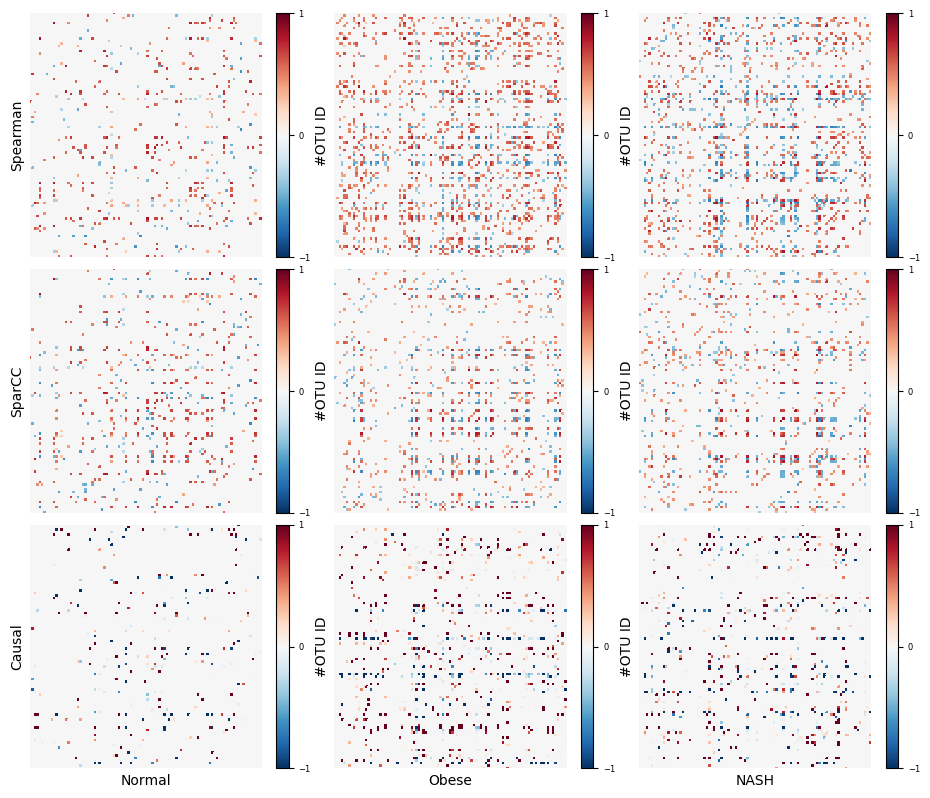

In [34]:
plot_disease = ['Normal', 'Obese', 'NASH']
plot_method = ['Spearman', 'SparCC', 'Causal']

_ = plt.figure(figsize=(10, 10), dpi=100)
gs = gridspec.GridSpec(3, 3)
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
r = 0
for m in plot_method:
    c = 0
    for d in plot_disease:
        ax = plt.subplot(gs[r, c])
        if m.lower() == 'causal':
            relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_final.csv', index_col=0, sep=',')
            p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided_final.csv', index_col=0, sep=',')
            prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep=',')
        else:
            relation = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'.csv', index_col=0, sep='\t')
            p_value = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep='\t')
            prior = np.ones(p_value.shape)
        
        relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
        subplot = sns.heatmap(relation, mask=None, cmap="RdBu_r", vmin=-1, vmax=1, cbar=False, annot=False,
                              fmt='.1g', annot_kws={'fontsize':5}, cbar_kws={'fontsize':5},
                              linewidths=0.0, xticklabels=True, yticklabels=True)
        cb = subplot.figure.colorbar(subplot.collections[0], ticks=[-1, 0, 1]) #显示colorbar
        _ = cb.ax.tick_params(labelsize=6) #设置colorbar刻度字体大小
        _ = subplot.tick_params(axis='both', which='both', labelsize=6, length=4, width=0, pad=0)
        if r < 2:
            _ = subplot.set_xticks([])
        if c > 0:
            _ = subplot.set_yticks([])
        ###
        _ = subplot.set_xticks([])
        _ = subplot.set_yticks([])
        ###
        if c == 0:
            _ = subplot.set_ylabel(m)
        if r == 2:
            _ = subplot.set_xlabel(d)
        c += 1
    r += 1

* 不同方法估计的菌种相互作用具有较大区别，相关（Spearman）构建的相互作用较多，假阳性高；SparCC能够去除部分假阳性；因果推理构建的菌种相互作用关系最少；
* 不同方法都可以发现Normal状态的菌种相互作用较稀疏；疾病Obese和NASH状态菌种相互作用关系较密集；

#### 2.2.2. 相互作用Scale-free性质（幂律分布）

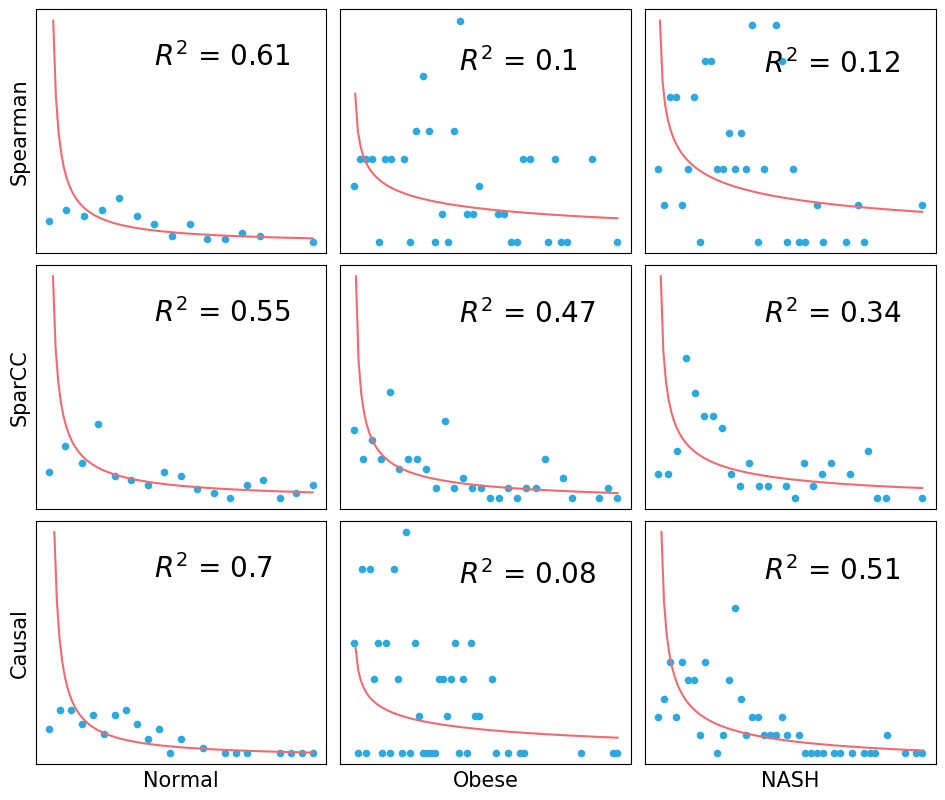

In [35]:
import statsmodels.api as sm
def powlaw_fiting(d, m):
    if m.lower() == 'causal':
        relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_final.csv', index_col=0, sep=',')
        p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided_final.csv', index_col=0, sep=',')
        prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep=',')
    else:
        relation = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'.csv', index_col=0, sep='\t')
        p_value = pd.read_csv(SPARCC_PATH+'counts_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep='\t')
        prior = np.ones(p_value.shape)
    relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
    degree = (relation!=0).sum().sum()
    res = {}
    for i in relation.columns:
        N = (relation[i]!=0).sum() + (relation.loc[i, :]!=0).sum()
        res[N] = res.get(N, 0) + 1
    X = []
    y = []
    for i, j in res.items():
        if i != 0:
            X.append([np.log10(i)])
            y.append(np.log10(j))
    X = np.array(X)
    X = sm.add_constant(X)
    ols = sm.OLS(y, X).fit()
    a = 10**ols.params[0]
    b = ols.params[1]
    yfunc = lambda x:a*(x**b)
    X_pred = np.linspace(0.5, max(res.keys()), 100)
    y_pred = [yfunc(i) for i in X_pred]
    return res, X_pred, y_pred, ols.rsquared

plot_disease = ['Normal', 'Obese', 'NASH']
plot_method = ['Spearman', 'SparCC', 'Causal']

fig = plt.figure(figsize=(10, 10), dpi=100)
gs = gridspec.GridSpec(3, 3)
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)

r = 0
for m in plot_method:
    c = 0
    for d in plot_disease:
        ax = plt.subplot(gs[r, c])
        degree, X_pred, y_pred, rsquared = powlaw_fiting(d, m)
        _ = plt.scatter(degree.keys(), degree.values(), color='#2ca9e1', s=20)
        _ = plt.plot(X_pred, y_pred, 'r-', label="Powlaw distribution fitting", color='#ec6d71')
        _ = plt.annotate('$R^2$ = '+str(round(rsquared, 2)),
                     xy=(max(X_pred)*0.4, max([max(y_pred), max(degree.values())])*0.8), fontsize=20)
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        ###
        if c == 0:
            _ = ax.set_ylabel(m, fontsize=15)
        if r == 2:
            _ = ax.set_xlabel(d, fontsize=15)
        c += 1
    r += 1
    #plt.xlabel('Degree')
    #plt.ylabel('Number of Nodes')

* 真实生物网络是具有Scale-free（Degree符合幂律分布）的网络结构；
* 因果推理构建的菌种互作网络（正常）相比于其他方法更加符合Scale-free特性；
* 相对于正常网络，疾病状态下，网络的Scale-free特性被破坏，特别是Obese状态中，更为明显；
* 推测：Obese是菌种互作结构发生变化的阶段，相互作用混乱；NASH状态已经达到相对稳定的疾病状态，网络结构进一步固定；因此，Obese状态具有更强的恢复潜力，由于其网络结构尚未固定；而NASH状态网络结构逐渐固定，恢复正常需要更强的外界干预；

#### 2.2.4 网络拓扑统计

In [38]:
def getFamily_Genus(tax):
    family = re.search(r'D_4__(.+?);', tax.strip()+';')
    genus = re.search(r'D_5__(.+?);', tax.strip()+';')
    family = family.group(1) if family else 'None'
    genus = genus.group(1) if genus else 'None'
    return family, genus

plot_disease = ['Normal', 'Obese', 'NASH']
res = []
family_links = {'Normal':{}, 'Obese':{}, 'NASH':{}}
degrees = {}
m = 'causal'
for d in plot_disease:
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+d.lower()+'_'+m.lower()+'_p_one_sided.csv', index_col=0, sep=',')
    
    relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
    degree = (relation!=0).sum().sum()
    degrees[d] = degree
    pos_degree = (relation>0).sum().sum()
    neg_degree = (relation<0).sum().sum()
    res.append([degree, pos_degree, neg_degree, pos_degree/float(neg_degree)])
    for i in relation.columns:
        f, g = getFamily_Genus(tax_df.loc[i, 'Taxon'])
        family_links[d][f] = family_links[d].get(f, 0) + (relation[i]!=0).sum()
res = pd.DataFrame(res, index=plot_disease, columns=['Degree', 'Positive', 'Negative', 'Pos/Neg'])
res
### Family
families = [i[0] for i in sorted(family_links['Normal'].items(), key=lambda x:x[1], reverse=True)]
res = []
for f in families:
    res.append([family_links['Normal'][f], family_links['Obese'][f], family_links['NASH'][f],
               (family_links['Obese'][f]/float(degrees['Obese']))/(family_links['Normal'][f]/float(degrees['Normal'])),
               (family_links['NASH'][f]/float(degrees['NASH']))/(family_links['Normal'][f]/float(degrees['Normal'])),
               (family_links['NASH'][f]/float(degrees['NASH']))/(family_links['Obese'][f]/float(degrees['Obese']))])
res = pd.DataFrame(res, index=families, columns=['Normal', 'Obese', 'NASH', 'Odd_Obese vs Normal', 'Odd_NASH vs Normal', 'Odd_NASH vs Obese'])
res

,Degree,Positive,Negative,Pos/Neg
Normal,308,150,158,0.949367
Obese,833,541,292,1.852740
NASH,673,364,309,1.177994


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


,Normal,Obese,NASH,Odd_Obese vs Normal,Odd_NASH vs Normal,Odd_NASH vs Obese
Lachnospiraceae,105,310,192,1.091637,0.836850,0.766601
Bacteroidaceae,85,125,183,0.543747,0.985298,1.812053
Family XI,38,73,89,0.710305,1.071870,1.509027
Ruminococcaceae,30,165,75,2.033613,1.144131,0.562610
Tannerellaceae,8,10,5,0.462185,0.286033,0.618871
Rikenellaceae,7,16,17,0.845138,1.111441,1.315100
Porphyromonadaceae,6,17,39,1.047619,2.974740,2.839525
Family XIII,6,2,7,0.123249,0.533928,4.332095
Streptococcaceae,5,15,3,1.109244,0.274591,0.247548
Peptostreptococcaceae,4,7,7,0.647059,0.800892,1.237741


* 疾病Obese和NASH中相互作用增加到2倍以上，正调控作用高于负调控作用，特别是在Obese状态中；
* Lachnospiraceae，Bacteroidaceae， Family XI和Ruminococcaceae是主要影响其他菌种的Family；
* 不同Family中，相互作用变化不同，Veillonellaceae等在Obese和NASH中调控作用都明显增加；Obese状态Prevotellaceae调控作用特异增加; NASH状态Burkholderiaceae调控作用特异增加；

(Veillonellaceae中部分菌种是可以作为动物的机会性病原体《the Family Veillonellaceae》; Prevotellaceae包含产生牙周病的机会性病原体《the Family Prevotellaceae》; Burkholderiaceae也包括了人和动物的主要病原体《the Family Burkholderiaceae》)

### 2.3. 相互作用网络菌种重要性和干预分析

#### 2.3.1 HITS网络节点重要性分析

In [39]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
def cal_RankSum(data, disease, ds1, ds2, tax, alpha = 0.01):
    res = []
    for i in data.columns:
        value1 = data.loc[disease==ds1, i]
        value2 = data.loc[disease==ds2, i]
        score, pvalue = ranksums(value1, value2)
        fold_change = value2.mean()/float(value1.mean()) if value1.mean() else np.nan
        res.append([i, tax.loc[i, 'Class'], tax.loc[i, 'Family'],tax.loc[i, 'Species'], value1.mean(), value2.mean(), fold_change, score, pvalue])
    res = pd.DataFrame(res, columns=['OTU', 'Class', 'Family', 'Species', ds1, ds2, 'FC', 'RankSum', 'p-value'])
    reject, fdr, _, _ = multipletests(list(res['p-value']), alpha=alpha, method='fdr_bh')
    res['FDR'] = fdr
    res = res.sort_values(by='FDR', ascending=True)
    res.index = range(len(res.index))
    return res

def build_Network(disease):
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided.csv', index_col=0, sep=',')
    
    edges = []
    nodes = []
    for target in relation.index:
        nodes.append(target)
        for source in relation.columns:
            if p_value.loc[target, source]<=INTERACTION_P_THRESHOLD and prior.loc[target, source]>=PRIOR_THRESHOLD:
                effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
                edges.append((source, target, effect))
    DG=nx.DiGraph()
    DG.add_nodes_from(nodes)
    DG.add_weighted_edges_from(edges)
    return DG

def random_Network(net):
    nodeset = list(net.nodes)
    redges = np.array([(i, j, float(v)) for i,j,v in net.edges.data('weight')])
    redges[:, 0] = [random.choice(nodeset) for i in range(len(redges))]
    redges[:, 1] = [random.choice(nodeset) for i in range(len(redges))]
    redges = [(i, j, float(v)) for i,j,v in redges]
    rnet = nx.DiGraph()
    rnet.add_nodes_from(nodeset)
    rnet.add_weighted_edges_from(redges)
    return rnet

def cal_HITS(net):
    h,a = nx.hits(net, max_iter=1000)
    return h, a

def cal_HITS_pvalue(net, h, rt=100):
    p_value = {}
    r = 0
    while(r<rt-1):
        try:
            rnet = random_Network(net)
            rh, ra = cal_HITS(rnet)
            for index in net.nodes:
                hi = h.get(index, 0)
                rhi = rh.get(index, 0)
                p_value[index] = p_value.get(index, 1)
                if rhi >= hi:
                    p_value[index] += 1
            r += 1
        except:
            pass
    for index in p_value.keys():
        p_value[index] = p_value[index]/float(rt)
    return p_value

def hits_score(d, tax, diff, d1, d2, times = 1000):
    net = build_Network(d)
    h, a = cal_HITS(net)
    p_value = cal_HITS_pvalue(net, h, rt=times)
    res = []
    for i in h.keys():
        res.append([i, tax.loc[i, 'Class'], tax.loc[i, 'Family'], tax.loc[i, 'Species'], tax.loc[i, 'Abb.']
                    , h[i], p_value[i], diff.loc[i, d1], diff.loc[i, d2], diff.loc[i, 'p-value'], diff.loc[i, 'FDR']])
    res = sorted(res, key=lambda x:x[2], reverse=True)
    res = pd.DataFrame(res, columns=['OTU', 'Class', 'Family', 'Species', 'Abb.', 'hits_score', 'hits_pval', d1, d2, 'abun_pval', 'abun_fdr'])
    return res

#p_times = 1000

#d = 'Normal'
#d1, d2 = ('Normal', 'NASH')
#diff = cal_RankSum(abun_df, DiseaseStatus, d1, d2, tax_species, alpha = 0.01)
#diff.index = diff['OTU']
#Normal_HITS = hits_score(d, tax_species, diff, d1, d2, times = p_times)
#Normal_HITS.head(10)

#d = 'Obese'
#d1, d2 = ('Normal', 'Obese')
#diff = cal_RankSum(abun_df, DiseaseStatus, d1, d2, tax_species, alpha = 0.01)
#diff.index = diff['OTU']
#Obese_HITS = hits_score(d, tax_species, diff, d1, d2, times = p_times)
#Obese_HITS.head(10)

#d = 'NASH'
#d1, d2 = ('Normal', 'NASH')
#diff = cal_RankSum(abun_df, DiseaseStatus, d1, d2, tax_species, alpha = 0.01)
#diff.index = diff['OTU']
#NASH_HITS = hits_score(d, tax_species, diff, d1, d2, times = p_times)
#NASH_HITS.head(10)

### Save
#Normal_HITS.to_csv(CAUSAL_PATH+'HITS/Normal_HITS.csv')
#Obese_HITS.to_csv(CAUSAL_PATH+'HITS/Obese_HITS.csv')
#NASH_HITS.to_csv(CAUSAL_PATH+'HITS/NASH_HITS.csv')

Normal_HITS = pd.read_csv(CAUSAL_PATH+'HITS/Normal_HITS.csv', index_col=0)
Obese_HITS = pd.read_csv(CAUSAL_PATH+'HITS/Obese_HITS.csv', index_col=0)
NASH_HITS = pd.read_csv(CAUSAL_PATH+'HITS/NASH_HITS.csv', index_col=0)

Normal_HITS[Normal_HITS['hits_pval']<0.05]
Obese_HITS[Obese_HITS['hits_pval']<0.05]
NASH_HITS[NASH_HITS['hits_pval']<0.05]


,OTU,Class,Family,Species,Abb.,hits_score,hits_pval,Normal,NASH,abun_pval,abun_fdr
18,42d8f985e8c26f2b842279c4d945a4e78743b687,Clostridiales,Ruminococcaceae,Faecalibacterium prausnitzii(OTU80),F. prausnitzii(OTU80),0.062001,0.001,5.158425,2.515622,0.011968,0.035180
27,f6944e5be5cca661767014ab95867c4dc3848235,Bacteroidales,Porphyromonadaceae,Porphyromonas loveana,P. loveana,0.033296,0.013,0.101074,0.697512,0.002213,0.010733
34,543e9142bfd56e3312822277113e06cbb521aa91,Clostridiales,Lachnospiraceae,Agathobacter ruminis(OTU2),A. ruminis(OTU2),0.064703,0.001,0.463473,0.142042,0.028680,0.069549
45,3ba90965ce76880f6bbcddc96b6ab309ac932ee1,Clostridiales,Lachnospiraceae,Blautia hansenii,B. hansenii,0.038297,0.012,0.241392,0.114492,0.005703,0.020489
49,4c6d7a5409ae36dbf1be703072de0fc8872933ca,Clostridiales,Lachnospiraceae,Anaerostipes caccae,A. caccae,0.036038,0.016,1.945535,0.586847,0.018018,0.044814
52,671e184eef8fe77c8d41237140afb0c9774475d5,Clostridiales,Lachnospiraceae,Lachnospiraceae(OTU55),Lachnospiraceae(OTU55),0.037581,0.009,0.251861,0.050801,0.004535,0.017598
57,53e93035aec5d823c3e67ec85c1bb14945ca2050,Clostridiales,Lachnospiraceae,Agathobacter ruminis(OTU75),A. ruminis(OTU75),0.072465,0.001,3.648412,1.832862,0.071309,0.138340
61,d32c3a758a590f2e70b54af0f90eceb9730958bc,Clostridiales,Lachnospiraceae,Lachnospiraceae(OTU85),Lachnospiraceae(OTU85),0.038147,0.014,0.087208,0.190666,0.329230,0.431559
63,58d72faf04d64350b1b6674360ced8602b36eb94,Clostridiales,Family XIII,S5-A14a(OTU76),S5-A14a(OTU76),0.036764,0.011,0.027149,0.301261,0.006527,0.022613
66,36b71e0fa60b370e95082d0cee5ba3ed92ea4f14,Clostridiales,Family XI,Finegoldia magna,F. magna,0.045952,0.006,0.024066,1.830496,0.000121,0.002353


,OTU,Class,Family,Species,Abb.,hits_score,hits_pval,Normal,Obese,abun_pval,abun_fdr
0,c84919371da9c309c2b7a50ab6ed836c0c9555e6,Selenomonadales,Veillonellaceae,Dialister pneumosintes,D. pneumosintes,0.033730,0.001,0.167141,0.582842,0.007526,0.034764
8,98896715b47780296c7b918cad24c28f4d058945,Clostridiales,Ruminococcaceae,Butyricicoccus sp. K4410.MGS-46,B. sp. K4410.MGS-46,0.033411,0.001,0.190732,0.150470,0.267372,0.441639
18,42d8f985e8c26f2b842279c4d945a4e78743b687,Clostridiales,Ruminococcaceae,Faecalibacterium prausnitzii(OTU80),F. prausnitzii(OTU80),0.031909,0.001,5.158425,2.248605,0.006948,0.033697
19,dc838e370410fb0d4763470f21542ac3f052167a,Clostridiales,Ruminococcaceae,Ruminococcaceae(OTU91),Ruminococcaceae(OTU91),0.022538,0.007,0.145083,0.083416,0.668929,0.767638
25,98cc48030d2670f4493685c3bb1fbd7bf2182cc5,Bacteroidales,Prevotellaceae,Prevotella buccalis,P. buccalis,0.042110,0.001,0.234791,1.171810,0.004240,0.022851
26,7ee6bdbeafe5f04b4d10a682bab889c7852be4cd,Bacteroidales,Porphyromonadaceae,Porphyromonas sp. 2007b,P. sp. 2007b,0.020527,0.016,0.024521,0.947344,0.001471,0.012969
37,ef71fca08a960f52b392e3f728c68d4779a06da8,Clostridiales,Lachnospiraceae,Ruminococcus torques,R. torques,0.017555,0.042,0.375376,0.136760,0.194901,0.363565
40,3af07d551903d8f0450ac42e478b0858857f99b5,Clostridiales,Lachnospiraceae,Lachnospiraceae(OTU18),Lachnospiraceae(OTU18),0.019597,0.022,0.219945,0.154601,0.678687,0.767638
43,b4039debc95fcd3157de7b17572bed80a93ae889,Clostridiales,Lachnospiraceae,Blautia producta(OTU32),B. producta(OTU32),0.035049,0.001,6.923962,1.690883,0.001341,0.012969
44,3ae4d87f6c2b8a813fb60f584165d9dd2821d2d5,Clostridiales,Lachnospiraceae,Coprococcus comes,C. comes,0.028196,0.001,0.687797,0.398277,0.148961,0.314114


,OTU,Class,Family,Species,Abb.,hits_score,hits_pval,Normal,NASH,abun_pval,abun_fdr
0,c84919371da9c309c2b7a50ab6ed836c0c9555e6,Selenomonadales,Veillonellaceae,Dialister pneumosintes,D. pneumosintes,0.024533,0.005,0.167141,1.211738,0.000542,0.004380
24,9075bd7b4542aad1faf685d8960946088cca0810,Bacteroidales,Rikenellaceae,Alistipes indistinctus(OTU57),A. indistinctus(OTU57),0.033386,0.001,1.108628,0.196282,0.005703,0.020489
26,7ee6bdbeafe5f04b4d10a682bab889c7852be4cd,Bacteroidales,Porphyromonadaceae,Porphyromonas sp. 2007b,P. sp. 2007b,0.033469,0.002,0.024521,0.964206,0.004535,0.017598
56,b301c74849d58d56977e3bfb75fff7c930096735,Clostridiales,Lachnospiraceae,Hungatella effluvii(OTU64),H. effluvii(OTU64),0.024808,0.009,0.021340,0.034048,0.515406,0.595171
60,82d482e629b615acdbb8a62b39115e47040c7d71,Clostridiales,Lachnospiraceae,Eubacterium ramulus,E. ramulus,0.018643,0.035,0.276804,0.147827,0.941079,0.950882
65,06a157c47ae3d15ba27d3409e47b2d1bda1228d9,Clostridiales,Family XI,Peptoniphilus lacrimalis,P. lacrimalis,0.038056,0.001,0.022793,0.402501,0.000750,0.005199
67,4055b3f1e3e0a8f04d0a83f7de0e7ca9fcdc0222,Clostridiales,Family XI,Peptoniphilus ivorii,P. ivorii,0.029229,0.001,0.147343,1.076928,0.000003,0.000168
68,6d16c8dfa0d7dce3f6e27a904b61a21c2be8d0f5,Clostridiales,Family XI,Peptoniphilus olsenii,P. olsenii,0.024100,0.007,0.083862,0.705046,0.000195,0.002680
69,c17c40fbf5843a9a0c17aa02432b3902ffe021a4,Clostridiales,Family XI,Ezakiella peruensis,E. peruensis,0.038421,0.001,0.188914,0.757100,0.000121,0.002353
74,595b5c69e0c0ab678b4b1457da6abbd3142afa3f,Betaproteobacteriales,Burkholderiaceae,Parasutterella secunda,P. secunda,0.033120,0.001,0.117388,0.789462,0.351690,0.454852


* Normal中HITS重要性显著高的菌种7个，Obese和NASH中各14个
* Lachnospiraceae， Family XI和Ruminococcaceae是Normal中主要的调控Family
* Obese和NASH中Lachnospiraceae， Family XI和Ruminococcaceae仍然较为重要，但也出现了像Prevotellaceae，Veillonellaceae，Burkholderiaceae家族的显著重要菌种，这几个菌种被报道可能与某些疾病有关；

#### 2.3.2 干预分析

In [44]:
### Find best pattern by Greedy algorithm
def build_Network(disease):
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided.csv', index_col=0, sep=',')
    edges = []
    nodes = []
    for target in relation.index:
        nodes.append(target)
        for source in relation.columns:
            if p_value.loc[target, source]<=INTERACTION_P_THRESHOLD and prior.loc[target, source]>=PRIOR_THRESHOLD:
                effect = 1.0 #1.0, abs(float(relation.loc[target, source]))
                edges.append((source, target, effect))
    DG=nx.DiGraph()
    DG.add_nodes_from(nodes)
    DG.add_weighted_edges_from(edges)
    return DG

def adjacency_matrix(disease):
    relation = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_final.csv', index_col=0, sep=',')
    p_value = pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided_final.csv', index_col=0, sep=',')
    prior = 1-pd.read_csv(CAUSAL_PATH+'abun_df_'+disease.lower()+'_causal_p_one_sided.csv', index_col=0, sep=',')
    relation *= (p_value<=INTERACTION_P_THRESHOLD)&(prior>=PRIOR_THRESHOLD)
    #relation = np.sign(relation)
    #for i in range(len(relation.index)):
    #    relation.iloc[i, i] = -1
    return relation

def get_delta_X(A, inventions, abundances, decay=0.5, max_iter=100):
    for it in range(max_iter):
        inventions += np.round(np.dot(A, inventions) * abundances * decay**(it), 5)
    return inventions

def intervention_score(abun_df, DiseaseStatus, from_state, to_state,intervention_list, decay=0.0,
                       is_overlap=False):
    A = adjacency_matrix(from_state)
    OTUs = list(A.columns)
    inventions = np.zeros(len(OTUs))
    from_abun = abun_df.loc[DiseaseStatus==from_state, OTUs].mean()
    to_abun = abun_df.loc[DiseaseStatus==to_state, OTUs].mean()
    net = build_Network(to_state)
    h, a = cal_HITS(net)
    hits_scores = np.array([h.get(i, 0.0) for i in OTUs])
    #hits_scores = np.array([1 for i in OTUs]) # 不考虑正常状态菌种重要性
    res = []
    for otu in intervention_list:
        if not is_overlap:
            inventions = np.zeros(len(OTUs))
        inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
        dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
        score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
        res.append([intervention_list.index(otu), otu, score])
    res = pd.DataFrame(res, columns=['Index', 'OTU', 'Score'])
    return res

def greedy_search(abun_df, DiseaseStatus, from_state, to_state, decay=0.0):
    A = adjacency_matrix(from_state)
    OTUs = list(A.columns)
    inventions = np.zeros(len(OTUs))
    from_abun = abun_df.loc[DiseaseStatus==from_state, OTUs].mean()
    to_abun = abun_df.loc[DiseaseStatus==to_state, OTUs].mean()
    net = build_Network(to_state)
    h, a = cal_HITS(net)
    hits_scores = np.array([h.get(i, 0.0) for i in OTUs])
    #hits_scores = np.array([1/97. for i in OTUs]) # 不考虑正常状态菌种重要性
    
    # single otu score
    single_score = []
    for otu in OTUs:
        inventions = np.zeros(len(OTUs))
        inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
        dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
        score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
        single_score.append([otu, score])
    
    # combine otu score
    current = []
    best_scores = []
    best_list = list(OTUs)
    final_best = []
    
    inventions = np.zeros(len(OTUs))
    for i in OTUs:
        inventions[OTUs.index(i)] = to_abun.loc[i] - from_abun.loc[i]
    dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
    allscore = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
    best_scores.append(allscore)
    
    while(len(best_list)>0):
        res = []
        for otu in best_list:
            current = list(best_list)
            current.remove(otu)
            # invention score
            inventions = np.zeros(len(OTUs))
            for i in current:
                inventions[OTUs.index(i)] = to_abun.loc[i] - from_abun.loc[i]
            dx = get_delta_X(A, inventions, from_abun, decay, max_iter=100)
            score = (np.sign(dx * (to_abun-from_abun)) * hits_scores).sum()
            res.append([otu, score])
        res = sorted(res, key=lambda x:x[1], reverse=True)
        best_list.remove(res[0][0])
        best_scores.append(res[0][1])
        final_best.append(res[0][0])
    return single_score, final_best, best_scores[:-1]

In [168]:
from_state = 'Obese'
to_state = 'Normal'
single_scores, best_list, best_scores = greedy_search(abun_df, DiseaseStatus, from_state, to_state, decay=0.0)
Obese_IS = Obese_HITS.copy()
Obese_IS.index = Obese_IS['OTU']
temp = Normal_HITS.copy()
temp.index = temp['OTU']
Obese_IS['normal_hits_score'] = [temp.loc[otu, 'hits_score'] for otu in Obese_IS.index]
Obese_IS['normal_hits_pval'] = [temp.loc[otu, 'hits_pval'] for otu in Obese_IS.index]
Obese_IS = Obese_IS.loc[best_list, ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                                    'normal_hits_pval', 'hits_score', 'hits_pval',
                                    to_state, from_state, 'abun_pval', 'abun_fdr']]
Obese_IS['Normal_Rank'] = [list(Normal_HITS['OTU']).index(i) for i in best_list]
Obese_IS['Obese_Rank'] = [list(Obese_HITS['OTU']).index(i) for i in best_list]
Obese_IS['IS'] = [dict(single_scores)[i] for i in best_list] # intervention_score
Obese_IS['CIS'] = best_scores # Cumulative_intervention_score
Obese_IS.columns = ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                    'normal_hits_pval', 'obese_hits_score', 'obese_hits_pval',
                    'normal_abun', 'obese_abun', 'abun_pval', 'abun_fdr',
                    'normal_hits_rank', 'obese_hits_rank', 'IS', 'CIS']

from_state = 'NASH'
to_state = 'Normal'
single_scores, best_list, best_scores = greedy_search(abun_df, DiseaseStatus, from_state, to_state, decay=0.0)
NASH_IS = NASH_HITS.copy()
NASH_IS.index = NASH_IS['OTU']
temp = Normal_HITS.copy()
temp.index = temp['OTU']
NASH_IS['normal_hits_score'] = [temp.loc[otu, 'hits_score'] for otu in NASH_IS.index]
NASH_IS['normal_hits_pval'] = [temp.loc[otu, 'hits_pval'] for otu in NASH_IS.index]
NASH_IS = NASH_IS.loc[best_list, ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                                    'normal_hits_pval', 'hits_score', 'hits_pval',
                                    to_state, from_state, 'abun_pval', 'abun_fdr']]
NASH_IS['Normal_Rank'] = [list(Normal_HITS['OTU']).index(i) for i in best_list]
NASH_IS['Obese_Rank'] = [list(NASH_HITS['OTU']).index(i) for i in best_list]
NASH_IS['IS'] = [dict(single_scores)[i] for i in best_list] # intervention_score
NASH_IS['CIS'] = best_scores # Cumulative_intervention_score
NASH_IS.columns = ['Class', 'Family', 'Species', 'Abb.', 'normal_hits_score',
                    'normal_hits_pval', 'nash_hits_score', 'nash_hits_pval',
                    'normal_abun', 'nash_abun', 'abun_pval', 'abun_fdr',
                    'normal_hits_rank', 'nash_hits_rank', 'IS', 'CIS']


In [537]:
#Obese_IS.to_csv(CAUSAL_PATH+'Obese_IS.csv')
#NASH_IS.to_csv(CAUSAL_PATH+'NASH_IS.csv')
#Obese_IS.to_csv(CAUSAL_PATH+'Obese_IS_nohits.csv')
#NASH_IS.to_csv(CAUSAL_PATH+'NASH_IS_nohits.csv')

,Class,Family,Species,Abb.,normal_hits_score,normal_hits_pval,obese_hits_score,obese_hits_pval,normal_abun,obese_abun,abun_pval,abun_fdr,normal_hits_rank,obese_hits_rank,IS,CIS,Rank
OTU,,,,,,,,,,,,,,,,,
7ee6bdbeafe5f04b4d10a682bab889c7852be4cd,Bacteroidales,Porphyromonadaceae,Porphyromonas sp. 2007b,P. sp. 2007b,0.001812,0.867,0.020527,0.016,0.024521,0.947344,0.001471,0.012969,26,26,0.239896,0.239896,1
53e93035aec5d823c3e67ec85c1bb14945ca2050,Clostridiales,Lachnospiraceae,Agathobacter ruminis(OTU75),A. ruminis(OTU75),0.072465,0.001,0.009917,0.516,3.648412,1.421079,0.032509,0.108738,57,57,0.238261,0.475067,2
4055b3f1e3e0a8f04d0a83f7de0e7ca9fcdc0222,Clostridiales,Family XI,Peptoniphilus ivorii,P. ivorii,0.052475,0.005,0.007726,0.740,0.147343,1.630741,0.000325,0.007877,67,67,0.186053,0.586786,3
78d664d8199a1a5050c114fb3669304f3d9a8d4e,Bacteroidales,Bacteroidaceae,Bacteroides zoogleoformans,B. zoogleoformans,0.001940,0.862,0.012516,0.273,0.153646,0.035095,0.008148,0.035924,95,95,0.088660,0.647245,4
4cef6fc61a9c38eea885a18cde8de772f7412697,Clostridiales,Lachnospiraceae,Clostridium amygdalinum,C. amygdalinum,0.012164,0.330,0.009274,0.570,0.009224,0.030544,0.172872,0.335372,38,38,0.028102,0.707910,5
58d72faf04d64350b1b6674360ced8602b36eb94,Clostridiales,Family XIII,S5-A14a(OTU76),S5-A14a(OTU76),0.036764,0.011,0.002635,0.993,0.027149,0.272228,0.006409,0.032722,63,63,0.073839,0.744674,6
795dbf8c019483a25ae9a8827a62a936185d84a0,Bacteroidales,Bacteroidaceae,Bacteroides barnesiae,B. barnesiae,0.001223,0.908,0.012057,0.302,1.275074,2.301110,0.688500,0.767638,96,96,-0.156157,0.775889,7
6d16c8dfa0d7dce3f6e27a904b61a21c2be8d0f5,Clostridiales,Family XI,Peptoniphilus olsenii,P. olsenii,0.011896,0.340,0.018036,0.042,0.083862,0.577881,0.003011,0.019559,68,68,0.148571,0.817475,8
67a04bc26f26894432770b3cc66a7ba0b0ac3cab,Bacteroidales,Bacteroidaceae,Bacteroides caecicola(OTU70),B. caecicola(OTU70),0.001666,0.892,0.012572,0.237,0.042593,0.052399,0.872600,0.910131,88,88,-0.011624,0.853511,9


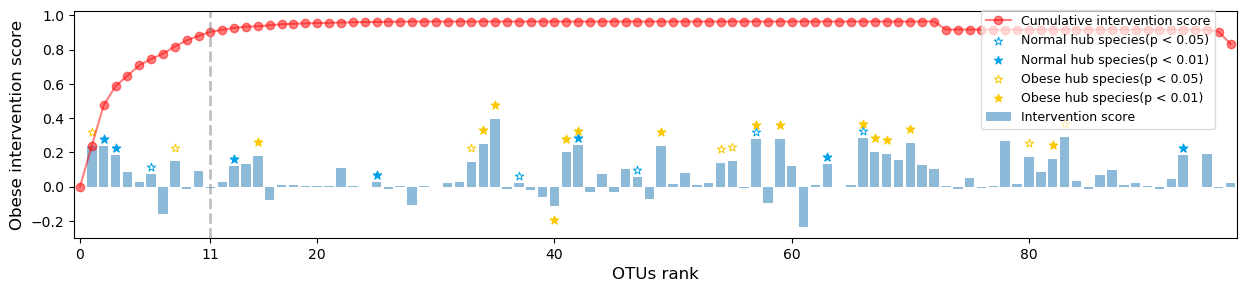

In [41]:
score_df = pd.read_csv(CAUSAL_PATH+'Obese_IS.csv', index_col=0)
score_df.head(10)

_ = plt.figure(1, (15, 3), dpi=100)
_ = plt.bar(range(1, len(score_df.index)+1), score_df['IS'], label='Intervention score', alpha=0.5)
cis = [0]
cis.extend(score_df['CIS'])
_ = plt.plot(range(0, len(score_df.index)+1), cis, 'r-', marker='o', label='Cumulative intervention score', alpha=0.5)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
Normal_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['normal_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[Normal_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['normal_hits_pval'])[Normal_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(Normal_keystone+1, y_loc+np.sign(y_loc)*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='white', lw=0.7, label='Normal hub species(p < 0.05)')
_ = plt.scatter(Normal_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='#00a1e9', lw=0.7, label='Normal hub species(p < 0.01)')




Obese_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['obese_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[Obese_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['obese_hits_pval'])[Obese_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(Obese_keystone+1, y_loc+np.sign(y_loc)*0.08, marker='*', s=40,
                color='#fcc800', facecolors='white', lw=0.7, label='Obese hub species(p < 0.05)')
_ = plt.scatter(Obese_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.08, marker='*', s=40,
                color='#fcc800', facecolors='#fcc800', lw=0.7, label='Obese hub species(p < 0.01)')

_ = plt.xlabel('OTUs rank',fontsize=12)
_ = plt.ylabel('Obese intervention score',fontsize=12)
_ = plt.axvline(11.0, alpha=0.5, color='gray', linestyle='--', lw=2)
_ = plt.xlim([-0.5, 97.5])
_ = plt.xticks([0, 11, 20, 40, 60, 80])
_ = plt.legend(fontsize=9, loc = (0.78, 0.48), frameon=True, framealpha=0.7)    
_ = plt.show()

,Class,Family,Species,Abb.,normal_hits_score,normal_hits_pval,nash_hits_score,nash_hits_pval,normal_abun,nash_abun,abun_pval,abun_fdr,normal_hits_rank,nash_hits_rank,IS,CIS,Rank
OTU,,,,,,,,,,,,,,,,,
f6944e5be5cca661767014ab95867c4dc3848235,Bacteroidales,Porphyromonadaceae,Porphyromonas loveana,P. loveana,0.033296,0.013,0.016913,0.083,0.101074,0.697512,0.002213,0.010733,27,27,0.345729,0.345729,1
9075bd7b4542aad1faf685d8960946088cca0810,Bacteroidales,Rikenellaceae,Alistipes indistinctus(OTU57),A. indistinctus(OTU57),0.002683,0.825,0.033386,0.001,1.108628,0.196282,0.005703,0.020489,24,24,0.206452,0.551970,2
c84919371da9c309c2b7a50ab6ed836c0c9555e6,Selenomonadales,Veillonellaceae,Dialister pneumosintes,D. pneumosintes,0.002090,0.852,0.024533,0.005,0.167141,1.211738,0.000542,0.004380,0,0,0.293870,0.663895,3
4c6d7a5409ae36dbf1be703072de0fc8872933ca,Clostridiales,Lachnospiraceae,Anaerostipes caccae,A. caccae,0.036038,0.016,0.007893,0.664,1.945535,0.586847,0.018018,0.044814,49,49,0.042253,0.663895,4
d32c3a758a590f2e70b54af0f90eceb9730958bc,Clostridiales,Lachnospiraceae,Lachnospiraceae(OTU85),Lachnospiraceae(OTU85),0.038147,0.014,0.006775,0.756,0.087208,0.190666,0.329230,0.431559,61,61,-0.038635,0.740189,5
795dbf8c019483a25ae9a8827a62a936185d84a0,Bacteroidales,Bacteroidaceae,Bacteroides barnesiae,B. barnesiae,0.001223,0.908,0.020311,0.024,1.275074,1.054548,0.193297,0.284088,96,96,0.110533,0.809351,6
b1c85b23cb036d5783eb5cb420b42d5816b804f1,Enterobacteriales,Enterobacteriaceae,Escherichia-Shigella(OTU88),Escherichia-Shigella(OTU88),0.001846,0.856,0.002470,0.977,0.384988,4.909103,0.011968,0.035180,71,71,0.061135,0.870017,7
b4039debc95fcd3157de7b17572bed80a93ae889,Clostridiales,Lachnospiraceae,Blautia producta(OTU32),B. producta(OTU32),0.021553,0.112,0.008519,0.624,6.923962,3.981416,0.003762,0.016588,43,43,0.196209,0.922736,8
7fe4f3b04e35b20bb4516344debfbb6154e330d3,Clostridiales,Ruminococcaceae,Faecalibacterium prausnitzii(OTU68),F. prausnitzii(OTU68),0.000000,1.000,0.003554,0.953,0.142129,0.042541,0.011968,0.035180,16,16,0.012322,0.935182,9


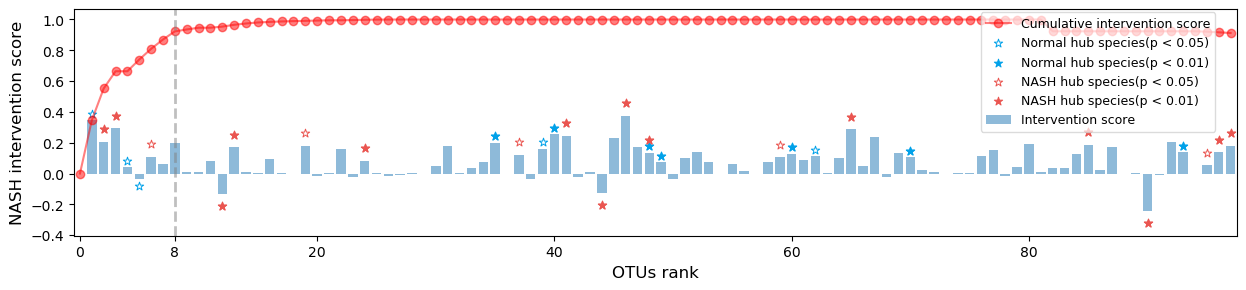

In [42]:
score_df = pd.read_csv(CAUSAL_PATH+'NASH_IS.csv', index_col=0)
score_df.head(10)

_ = plt.figure(1, (15, 3), dpi=100)
_ = plt.bar(range(1, len(score_df.index)+1), score_df['IS'], label='Intervention score', alpha=0.5)
cis = [0]
cis.extend(score_df['CIS'])
_ = plt.plot(range(0, len(score_df.index)+1), cis, 'r-', marker='o', label='Cumulative intervention score', alpha=0.5)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
Normal_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['normal_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[Normal_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['normal_hits_pval'])[Normal_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(Normal_keystone+1, y_loc+np.sign(y_loc)*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='white', lw=0.7, label='Normal hub species(p < 0.05)')
_ = plt.scatter(Normal_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.04, marker='*', s=40,
                color='#00a1e9', facecolors='#00a1e9', lw=0.7, label='Normal hub species(p < 0.01)')

NASH_keystone = np.array([i for i in range(len(score_df.index)) if list(score_df['nash_hits_pval'])[i]<=0.05])
y_loc = np.array(score_df['IS'])[NASH_keystone]
fdr001 = [True if i<=0.01 else False for i in np.array(score_df['nash_hits_pval'])[NASH_keystone]]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
_ = plt.scatter(NASH_keystone+1, y_loc+np.sign(y_loc)*0.08, marker='*', s=40,
                color='#ea5550', facecolors='white', lw=0.7, label='NASH hub species(p < 0.05)')
_ = plt.scatter(NASH_keystone[fdr001]+1, y_loc[fdr001]+np.sign(y_loc[fdr001])*0.08, marker='*', s=40,
                color='#ea5550', facecolors='#ea5550', lw=0.7, label='NASH hub species(p < 0.01)')

_ = plt.xlabel('OTUs rank',fontsize=12)
_ = plt.ylabel('NASH intervention score',fontsize=12)
_ = plt.axvline(8.0, alpha=0.5, color='gray', linestyle='--', lw=2)
_ = plt.xlim([-0.5, 97.5])
_ = plt.xticks([0, 8, 20, 40, 60, 80])
_ = plt.legend(fontsize=9, loc = (0.78, 0.46), frameon=True, framealpha=0.7)    
_ = plt.show()

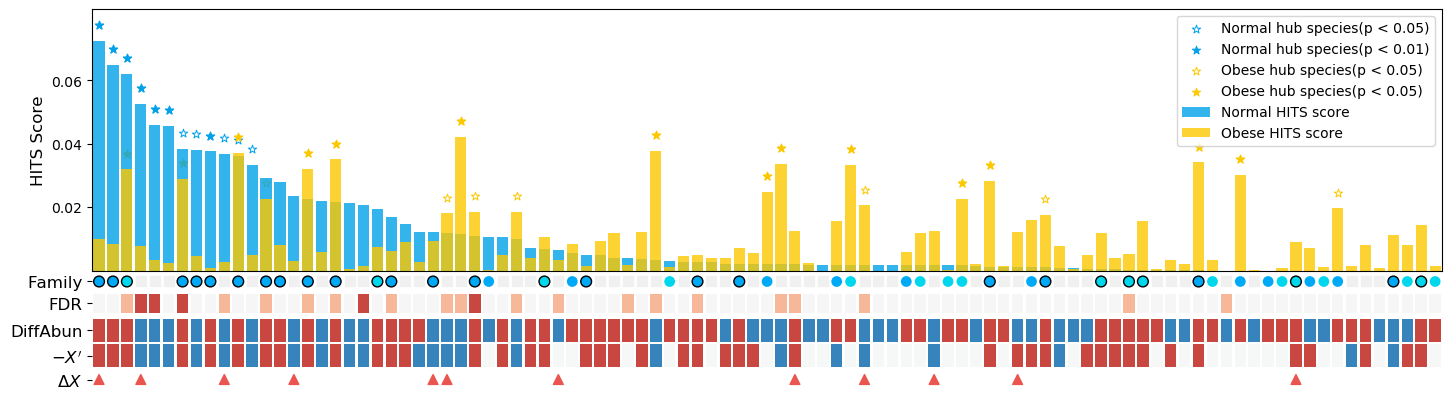

In [64]:
Obese_IS = pd.read_csv(CAUSAL_PATH+'Obese_IS.csv', index_col=0)

A = adjacency_matrix('Obese')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='Obese', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(Obese_IS.index)[:11]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

########### Plot ###########
dx_df = copy.deepcopy(Obese_IS)
dx_df = dx_df.sort_values('normal_hits_score', ascending=False)
dx_df['Diff'] = np.sign(dx_df['obese_abun'] - dx_df['normal_abun'])
dx_df['-Delta X'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['Index'] = range(len(dx_df.index))

_ = plt.figure(figsize=(15, 5), dpi=100)
gs = gridspec.GridSpec(5, 1, height_ratios=[0.72, 0.04, 0.06, 0.14, 0.04])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
ax = plt.subplot(gs[0, 0])
_ = plt.bar(dx_df.index, dx_df['normal_hits_score'], label='Normal HITS score', alpha=0.8, color='#00a1e9')
_ = plt.bar(dx_df.index, dx_df['obese_hits_score'], label='Obese HITS score', alpha=0.8, color='#fcc800')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'normal_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'normal_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'normal_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#00a1e9', facecolors='white', lw=0.7,
                label='Normal hub species(p < 0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#00a1e9', facecolors='#00a1e9', lw=0.7,
                label='Normal hub species(p < 0.01)')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'obese_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'obese_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'obese_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#fcc800', facecolors='white', lw=0.7,
                label='Obese hub species(p < 0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#fcc800', facecolors='#fcc800', lw=0.7,
                label='Obese hub species(p < 0.05)')

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0.02, 0.04, 0.06])
_ = plt.ylabel('HITS Score', fontsize=12)
_ = plt.legend(fontsize=10)

#############
colors = {'Family XI':'#006dd6', 'Lachnospiraceae':'#00a9f5', 'Ruminococcaceae':'#00d6ec',
         'Peptostreptococcaceae':'#a1e3f5', 'Family XIII':'#a4fbfb', 'Bacteroidaceae':'#ff0000',
         'Prevotellaceae':'#ff5700', 'Rikenellaceae':'#ff9093', 'Marinifilaceae':'#ff64b9',
         'Porphyromonadaceae':'#ffabd5', 'Tannerellaceae':'#ffdadb', 'Leuconostocaceae':'#31c000',
         'Streptococcaceae':'#a0ef6c', 'Veillonellaceae':'#ffc200', 'Burkholderiaceae':'#ff00ff',
         'Bifidobacteriaceae':'#de76de', 'Enterobacteriaceae':'#eda5ff', 'Campylobacteraceae':'#f6c9f6',
         'Desulfovibrionaceae':'#ffd5ff'}
#colors = {'Family XI':'#006dd6', 'Lachnospiraceae':'#00a9f5', 'Ruminococcaceae':'#00d6ec'}
ax = plt.subplot(gs[1, 0])
color = [colors.get(dx_df.loc[i, 'Family'], '#f0f0f0') for i in dx_df.index]
for f in colors.keys():
    sub_df = dx_df.loc[dx_df['Family']==f, :]
    lw = [1 if sub_df.loc[i, 'Diff']==sub_df.loc[i, '-Delta X'] else 0 for i in sub_df.index]
    if f == 'Lachnospiraceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=60,
                        color=colors[f], lw=lw, edgecolors='black')
    elif f == 'Ruminococcaceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=60,
                        color=colors[f], lw=lw, edgecolors='black')
    else:
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='s', s=60, color='#f0f0f0')
#_ = plt.scatter(dx_df.index, [0 for i in dx_df.index], marker='s', s=60, color=color)

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['Family'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)
#############

ax = plt.subplot(gs[2, 0])
heatmap_data = np.array([[1 if i<0.01 else (0.5 if i<=0.05 else 0) for i in dx_df['abun_fdr']]])
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu_r", n_colors=5), cbar=False)
_ = hp.set_xticks([])
_ = hp.set_yticklabels(['FDR'], rotation=360, fontsize=12)

ax = plt.subplot(gs[3, 0])
heatmap_data = dx_df.loc[:, ['-Delta X', 'Diff']].T
heatmap_data.columns = range(len(heatmap_data.columns))
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu", n_colors=5), cbar=False)
_ = hp.set_yticklabels(["$-X'$", 'DiffAbun'], rotation=0, fontsize=12)
_ = hp.set_ylim([0, 2])
_ = hp.set_xticks([])

ax = plt.subplot(gs[4, 0])
s = [50 if i in list(Obese_IS.index)[:12] else 0 for i in dx_df.index]
_ = plt.scatter(dx_df.index, [0 for i in dx_df.index], marker='^', s=s, color='#ea5550')
#x = np.array([list(dx_df.index).index(otu) for otu in list(NASH_IS.index)[:8]])
#_ = plt.scatter(x, [0 for i in x], marker='^', color='#ea5550')
_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['$\Delta X$'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)

plt.show()

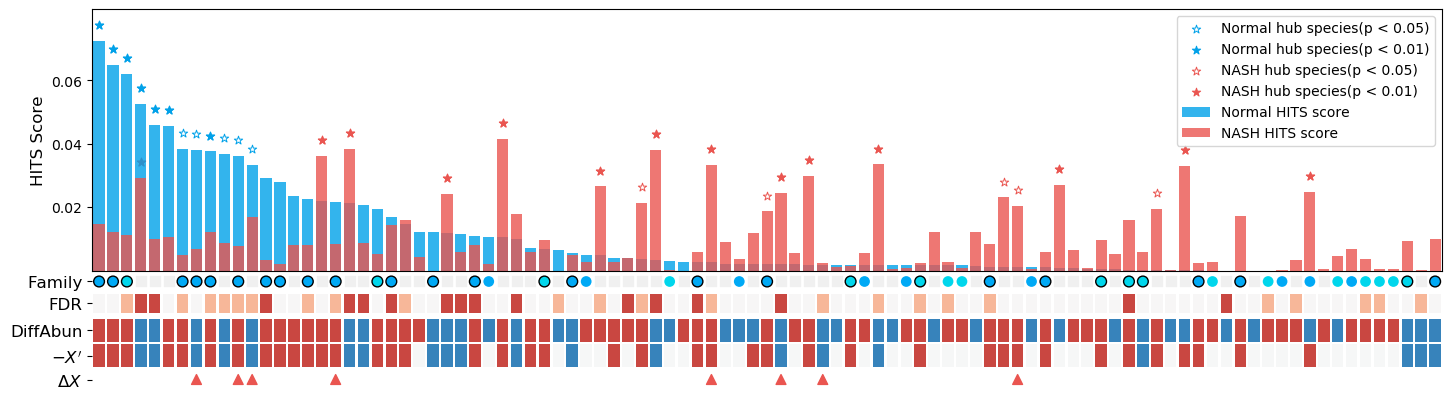

In [66]:
NASH_IS = pd.read_csv(CAUSAL_PATH+'NASH_IS.csv', index_col=0)

A = adjacency_matrix('NASH')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='NASH', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(NASH_IS.index)[:8]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

########### Plot ###########
dx_df = copy.deepcopy(NASH_IS)
dx_df = dx_df.sort_values('normal_hits_score', ascending=False)
dx_df['Diff'] = np.sign(dx_df['nash_abun'] - dx_df['normal_abun'])
dx_df['-Delta X'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['Index'] = range(len(dx_df.index))

_ = plt.figure(figsize=(15, 5), dpi=100)
gs = gridspec.GridSpec(5, 1, height_ratios=[0.72, 0.04, 0.06, 0.14, 0.04])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)

# '#00a1e9' # 蓝色 '#ea5550' # 红色 '#fcc800' # 黄色
ax = plt.subplot(gs[0, 0])
_ = plt.bar(dx_df.index, dx_df['normal_hits_score'], label='Normal HITS score', alpha=0.8, color='#00a1e9')
_ = plt.bar(dx_df.index, dx_df['nash_hits_score'], label='NASH HITS score', alpha=0.8, color='#ea5550')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'normal_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'normal_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'normal_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#00a1e9', facecolors='white', lw=0.7,
                label='Normal hub species(p < 0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#00a1e9', facecolors='#00a1e9', lw=0.7,
                label='Normal hub species(p < 0.01)')

x = np.array([i for i in dx_df.index if dx_df.loc[i, 'nash_hits_pval']<=0.05])
fdr001 = [True if i<=0.01 else False for i in dx_df.loc[x, 'nash_hits_pval']]
fdr001 = [i for i in range(len(fdr001)) if fdr001[i]]
y = dx_df.loc[x, 'nash_hits_score']+0.005
_ = plt.scatter(x, y, marker='*', s=40, color='#ea5550', facecolors='white', lw=0.7,
                label='NASH hub species(p < 0.05)')
_ = plt.scatter(x[fdr001], y[fdr001], marker='*', s=40, color='#ea5550', facecolors='#ea5550', lw=0.7,
                label='NASH hub species(p < 0.01)')

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0.02, 0.04, 0.06])
_ = plt.ylabel('HITS Score', fontsize=12)
_ = plt.legend(fontsize=10)
#############
colors = {'Family XI':'#006dd6', 'Lachnospiraceae':'#00a9f5', 'Ruminococcaceae':'#00d6ec',
         'Peptostreptococcaceae':'#a1e3f5', 'Family XIII':'#a4fbfb', 'Bacteroidaceae':'#ff0000',
         'Prevotellaceae':'#ff5700', 'Rikenellaceae':'#ff9093', 'Marinifilaceae':'#ff64b9',
         'Porphyromonadaceae':'#ffabd5', 'Tannerellaceae':'#ffdadb', 'Leuconostocaceae':'#31c000',
         'Streptococcaceae':'#a0ef6c', 'Veillonellaceae':'#ffc200', 'Burkholderiaceae':'#ff00ff',
         'Bifidobacteriaceae':'#de76de', 'Enterobacteriaceae':'#eda5ff', 'Campylobacteraceae':'#f6c9f6',
         'Desulfovibrionaceae':'#ffd5ff'}
#colors = {'Family XI':'#006dd6', 'Lachnospiraceae':'#00a9f5', 'Ruminococcaceae':'#00d6ec'}
ax = plt.subplot(gs[1, 0])
color = [colors.get(dx_df.loc[i, 'Family'], '#f0f0f0') for i in dx_df.index]
for f in colors.keys():
    sub_df = dx_df.loc[dx_df['Family']==f, :]
    lw = [1 if sub_df.loc[i, 'Diff']==sub_df.loc[i, '-Delta X'] else 0 for i in sub_df.index]
    if f == 'Lachnospiraceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=60,
                        color=colors[f], lw=lw, edgecolors='black')
    elif f == 'Ruminococcaceae':
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='o', s=60,
                        color=colors[f], lw=lw, edgecolors='black')
    else:
        _ = plt.scatter(sub_df['Index'], [0 for i in sub_df.index], marker='s', s=60, color='#f0f0f0')

_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['Family'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)
#############
ax = plt.subplot(gs[2, 0])
heatmap_data = np.array([[1 if i<0.01 else (0.5 if i<=0.05 else 0) for i in dx_df['abun_fdr']]])
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu_r", n_colors=5), cbar=False)
_ = hp.set_xticks([])
_ = hp.set_yticklabels(['FDR'], rotation=360, fontsize=12)

ax = plt.subplot(gs[3, 0])
heatmap_data = dx_df.loc[:, ['-Delta X', 'Diff']].T
heatmap_data.columns = range(len(heatmap_data.columns))
hp = sns.heatmap(heatmap_data, vmin=-1, vmax=1, linewidths=1, cmap=sns.color_palette("RdBu", n_colors=5), cbar=False)
_ = hp.set_yticklabels(["$-X'$", 'DiffAbun'], rotation=0, fontsize=12)
_ = hp.set_ylim([0, 2])
_ = hp.set_xticks([])

ax = plt.subplot(gs[4, 0])
s = [50 if i in list(NASH_IS.index)[:8] else 0 for i in dx_df.index]
_ = plt.scatter(dx_df.index, [0 for i in dx_df.index], marker='^', s=s, color='#ea5550')
#x = np.array([list(dx_df.index).index(otu) for otu in list(NASH_IS.index)[:8]])
#_ = plt.scatter(x, [0 for i in x], marker='^', color='#ea5550')
_ = plt.xlim([-0.5, len(dx_df.index)-0.5])
_ = plt.xticks([])
_ = plt.yticks([0], ['$\Delta X$'], fontsize=12)
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['bottom'].set_visible(False)
_ = ax.spines['left'].set_visible(False)

plt.show()

In [73]:
NASH_IS = pd.read_csv(CAUSAL_PATH+'NASH_IS.csv', index_col=0)
dx_df = copy.deepcopy(NASH_IS)
dx_df = dx_df.sort_values('normal_hits_score', ascending=False)
dx_df['Diff_sign'] = np.sign(dx_df['nash_abun'] - dx_df['normal_abun'])

### 1
A = adjacency_matrix('NASH')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='NASH', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(NASH_IS.index)[:1]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

dx_df['-DX_top1'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['top1_interve'] = 0+(dx_df['-DX_top1']!=0) + (dx_df['Diff_sign']==dx_df['-DX_top1'])
dx_df.loc[list(NASH_IS.index)[:1], 'top1_interve'] = 'Interve'
dx_df = dx_df.loc[:, ['IS', 'Diff_sign', '-DX_top1', 'top1_interve']]

### 2
A = adjacency_matrix('NASH')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='NASH', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(NASH_IS.index)[1:2]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

dx_df['-DX_top2'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['top2_interve'] = 0+(dx_df['-DX_top2']!=0) + (dx_df['Diff_sign']==dx_df['-DX_top2'])
dx_df.loc[list(NASH_IS.index)[1:2], 'top2_interve'] = 'Interve'

### 3
A = adjacency_matrix('NASH')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='NASH', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(NASH_IS.index)[2:3]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

dx_df['-DX_top3'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['top3_interve'] = 0+(dx_df['-DX_top3']!=0) + (dx_df['Diff_sign']==dx_df['-DX_top3'])
dx_df.loc[list(NASH_IS.index)[2:3], 'top3_interve'] = 'Interve'

### 123
A = adjacency_matrix('NASH')
OTUs = list(A.columns)
inventions = np.zeros(len(OTUs))
from_abun = abun_df.loc[DiseaseStatus=='NASH', OTUs].mean()
to_abun = abun_df.loc[DiseaseStatus=='Normal', OTUs].mean()
for otu in list(NASH_IS.index)[:3]:
    inventions[OTUs.index(otu)] = to_abun.loc[otu] - from_abun.loc[otu]
dx = get_delta_X(A, inventions, from_abun, decay=0.0, max_iter=100)
dx = pd.DataFrame(np.array([dx]).T, columns=['DX'], index=OTUs)

dx_df['-DX_top123'] = -np.sign([dx.loc[i, 'DX'] for i in dx_df.index])
dx_df['top123_interve'] = 0+(dx_df['-DX_top123']!=0) + (dx_df['Diff_sign']==dx_df['-DX_top123'])
dx_df.loc[list(NASH_IS.index)[:3], 'top123_interve'] = 'Interve'
dx_df['Family'] = [tax_species.loc[otu, 'Family'] for otu in dx_df.index]
dx_df['Species'] = [tax_species.loc[otu, 'Species'] for otu in dx_df.index]
dx_df['Abb.'] = [tax_species.loc[otu, 'Abb.'] for otu in dx_df.index]
dx_df.head()
dx_df.to_csv(CAUSAL_PATH+'Interve.csv')

,IS,Diff_sign,-DX_top1,top1_interve,-DX_top2,top2_interve,-DX_top3,top3_interve,-DX_top123,top123_interve,Family,Species,Abb.
OTU,,,,,,,,,,,,,
53e93035aec5d823c3e67ec85c1bb14945ca2050,0.254080,-1.0,-1.0,2,-0.0,0,-1.0,2,-1.0,2,Lachnospiraceae,Agathobacter ruminis(OTU75),A. ruminis(OTU75)
543e9142bfd56e3312822277113e06cbb521aa91,0.137668,-1.0,-1.0,2,-0.0,0,-1.0,2,-1.0,2,Lachnospiraceae,Agathobacter ruminis(OTU2),A. ruminis(OTU2)
42d8f985e8c26f2b842279c4d945a4e78743b687,0.200401,-1.0,-0.0,0,-0.0,0,-1.0,2,-1.0,2,Ruminococcaceae,Faecalibacterium prausnitzii(OTU80),F. prausnitzii(OTU80)
4055b3f1e3e0a8f04d0a83f7de0e7ca9fcdc0222,0.136278,1.0,-0.0,0,1.0,2,-0.0,0,1.0,2,Family XI,Peptoniphilus ivorii,P. ivorii
36b71e0fa60b370e95082d0cee5ba3ed92ea4f14,0.129099,1.0,-0.0,0,-0.0,0,-0.0,0,-0.0,0,Family XI,Finegoldia magna,F. magna


Diff: Normal到NASH菌种丰度变化；-Delta X：NASH状态中，菌种干预后的丰度变化 (为了明显比较丰度变化，取了负值)；红色丰度升高，蓝色丰度下降；
* Normal网络中最重要的12个菌种具有很好的干预效果，在干预NASH状态后，能够将NASH中失衡的菌种朝Normal状态丰度进行调节。
* Normal到NASH丰度显著差异变化的菌种(FDR<=0.01：红色，FDR<=0.05：浅红色，FDR>0.05：白色)大多都能通过干预较好地反向调控，其余部分无法准确调控的菌种要不重要性较低，要不并不显著差异；

前12个高效干预菌种主要属于梭菌目（Clostridiales）中的毛螺菌科（Lachnospiraceae）等；以及两个拟杆菌目（Bacteroidales）的菌种；

12个高效干预菌种在正常疾病状态中有着丰度变化，特别是Family XI中的几个菌种，差异最为显著；同时，这些菌种对于不同状态样本的分辨效果很好；

# Function Enrich

In [676]:
path = '/Users/dingfengwu/Desktop/NAFLD3/function/'

In [781]:
ko_data = pd.read_csv(path+'ko.txt', sep='\t', header=None)
all_kos = [i.split(':')[1] for i in list(ko_data[0])]
rn_data = pd.read_csv(path+'rn.txt', sep='\t', header=None)
all_rns = [i.split(':')[1] for i in list(rn_data[0])]
md_data = pd.read_csv(path+'md.txt', sep='\t', header=None)
all_mds = [i.split(':')[1] for i in list(md_data[0])]
pt_data = pd.read_csv(path+'path.txt', sep='\t', header=None)
all_pts = [i.split(':')[1] for i in list(pt_data[0])]

md_data.index = [i.split(':')[1] for i in md_data[0]]
rn_data.index = [i.split(':')[1] for i in rn_data[0]]
pt_data.index = [i.split(':')[1] for i in pt_data[0]]
len(all_kos), len(all_rns), len(all_mds), len(all_pts)

(23054, 11296, 394, 536)

In [782]:
rn2ko_data = pd.read_csv(path+'rn2ko.txt', sep='\t', header=None)
rn_list = set()
ko_list = set()
rn2ko = {}
for i in rn2ko_data.index:
    rn = rn2ko_data.loc[i, 1].split('rn:')[1].strip()
    ko = rn2ko_data.loc[i, 0].split('ko:')[1].strip()
    rn_list.add(rn)
    ko_list.add(ko)
    rn2ko[rn] = rn2ko.get(rn, set())
    rn2ko[rn].add(ko)
print(len(rn_list), len(ko_list))
sorted([len(i) for i in rn2ko.values()], reverse=True)[:5]

md2ko_data = pd.read_csv(path+'md2ko.txt', sep='\t', header=None)
md_list = set()
ko_list2 = set()
md2ko = {}
for i in md2ko_data.index:
    md = md2ko_data.loc[i, 1].split('md:')[1].strip()
    ko = md2ko_data.loc[i, 0].split('ko:')[1].strip()
    md_list.add(md)
    ko_list2.add(ko)
    md2ko[md] = md2ko.get(md, set())
    md2ko[md].add(ko)
    #print(md, ko)
print(len(md_list), len(ko_list2))
sorted([len(i) for i in md2ko.values()], reverse=True)[:5]
len(set(ko_list)|set(ko_list2))

pt2ko_data = pd.read_csv(path+'path2ko.txt', sep='\t', header=None)
pt2ko = {}
for i in pt2ko_data.index:
    pt = pt2ko_data.loc[i, 1].split(':')[1].strip()
    ko = pt2ko_data.loc[i, 0].split(':')[1].strip()
    if 'map' in pt:
        pt2ko[pt] = pt2ko.get(pt, set())
        pt2ko[pt].add(ko)

sorted([len(i) for i in pt2ko.values()], reverse=True)[:5]


6459 5388


[49, 27, 27, 27, 23]

388 2344


[43, 40, 37, 34, 31]

5806

[4121, 1194, 1180, 1016, 515]

In [783]:
species = ['pah', 'pcre', 'pgi', 'pgn', 'pgt', 'ash', 'afd', 'dpn']
s2ko = {}
for s in species:
    kos = [i.split(':')[1] for i in pd.read_csv(path+'KOs/'+s+'.txt', sep='\t', header=None)[0]]
    s2ko[s] = set(kos)

In [784]:
# Enrich
from scipy.stats import fisher_exact

def func_enrich(terms, mapping, species, s2ko):
    ###########################################################################
    #        #        |  KO in Species  | KO Not in species  |  All KOs       #
    # KO in func      |        a        |          b         |   a + b        #
    # KO not in Func  |        c        |          d         |   c + d        #
    #      all        |      a + c      |        b + d       | a + b + c + d  #
    ###########################################################################
    res = []
    for t in terms:
        term_kos = mapping.get(t, set())
        row = [len(term_kos)]
        for s in species:
            species_kos = s2ko[s]
            overlap_kos = term_kos&species_kos
            #if len(overlap_kos)<5:
            #    continue
            a = len(overlap_kos)
            b = len(term_kos) - a
            c = len(species_kos) - a
            d = len(all_kos) - len(term_kos) - c
            oddsratio, pval = fisher_exact([[a, b], [c, d]])
            #print(t, s, oddsratio, pval)
            row.extend([len(overlap_kos), oddsratio, pval])
        res.append(row)
    columns = ['KO_in_term']
    for s in species:
        columns.extend(['KO_in_'+s, s+'_OddsRatio', s+'_pval'])
    res = pd.DataFrame(res, columns=columns, index = terms)
    res = res.sort_values([s+'_pval' for s in species])
    ### fdr
    alpha = 0.01
    columns = ['KO_in_term']
    for s in species:
        reject, fdr, _, _ = multipletests(list(res[s+'_pval']), alpha=alpha, method='fdr_bh')
        res[s+'_fdr'] = fdr
        columns.extend(['KO_in_'+s, s+'_OddsRatio', s+'_pval', s+'_fdr'])
    res = res.loc[:, columns]
    return res

rn_enrich = func_enrich(all_rns, rn2ko, species, s2ko)
md_enrich = func_enrich(all_mds, md2ko, species, s2ko)
pt_enrich = func_enrich(all_pts, pt2ko, species, s2ko)

In [789]:
rn_enrich.head()

,KO_in_term,KO_in_pah,pah_OddsRatio,pah_pval,pah_fdr,KO_in_pcre,pcre_OddsRatio,pcre_pval,pcre_fdr,KO_in_pgi,...,ash_pval,ash_fdr,KO_in_afd,afd_OddsRatio,afd_pval,afd_fdr,KO_in_dpn,dpn_OddsRatio,dpn_pval,dpn_fdr
R01197,4,4,inf,0.000001,0.015383,4,inf,0.000001,0.014393,4,...,0.000001,0.015383,4,inf,0.000003,0.033480,0,0.000000,1.000000,1.0
R01221,6,4,56.721019,0.000019,0.109178,4,57.709845,0.000018,0.102240,4,...,0.000739,0.734145,4,46.318658,0.000042,0.156508,0,0.000000,1.000000,1.0
R01082,4,3,84.977099,0.000156,0.586149,3,86.456662,0.000148,0.557857,1,...,0.130035,1.000000,1,7.695228,0.156151,1.000000,1,10.382613,0.118885,1.0
R03660,2,2,inf,0.001170,0.880974,2,inf,0.001132,1.000000,2,...,0.001170,0.734145,2,inf,0.001725,0.695938,2,inf,0.000969,1.0
R05627,2,2,inf,0.001170,0.880974,2,inf,0.001132,1.000000,2,...,0.001170,0.734145,2,inf,0.001725,0.695938,2,inf,0.000969,1.0


In [786]:
md_enrich.head()

,KO_in_term,KO_in_pah,pah_OddsRatio,pah_pval,pah_fdr,KO_in_pcre,pcre_OddsRatio,pcre_pval,pcre_fdr,KO_in_pgi,...,ash_pval,ash_fdr,KO_in_afd,afd_OddsRatio,afd_pval,afd_fdr,KO_in_dpn,dpn_OddsRatio,dpn_pval,dpn_fdr
M00122,10,8,114.023047,7.697722e-11,1.657734e-08,7,67.587776,5.236141e-09,2.292266e-07,6,...,4.387067e-02,0.205774,2,5.776151,6.220665e-02,2.817175e-01,1,3.459941,2.712747e-01,1.000000
M00173,43,14,13.851123,8.414893e-11,1.657734e-08,14,14.095665,6.760916e-11,1.331900e-08,12,...,1.373395e-08,0.000001,12,9.028848,1.153254e-07,4.130748e-06,4,3.202902,4.418750e-02,0.300391
M00051,15,9,42.805769,2.562226e-10,3.365057e-08,9,43.556714,2.211605e-10,2.904575e-08,9,...,6.055737e-06,0.000108,9,34.915701,1.422212e-09,1.120703e-07,7,27.478200,1.428607e-07,0.000008
M00011,34,12,15.614602,6.518391e-10,6.420615e-08,12,15.889576,5.395815e-10,5.314877e-08,10,...,1.295762e-07,0.000005,10,9.701125,7.733364e-07,1.692747e-05,1,0.942606,1.000000e+00,1.000000
M00096,9,7,99.642583,1.816560e-09,1.431449e-07,7,101.386216,1.618041e-09,9.107258e-08,7,...,1.212805e-07,0.000005,7,81.313354,7.007434e-09,3.944185e-07,6,62.733146,6.930897e-08,0.000005


In [787]:
pt_enrich.head()

,KO_in_term,KO_in_pah,pah_OddsRatio,pah_pval,pah_fdr,KO_in_pcre,pcre_OddsRatio,pcre_pval,pcre_fdr,KO_in_pgi,...,ash_pval,ash_fdr,KO_in_afd,afd_OddsRatio,afd_pval,afd_fdr,KO_in_dpn,dpn_OddsRatio,dpn_pval,dpn_fdr
map03010,143,57,20.082015,9.815433e-46,2.741732e-43,56,19.838697,7.807293e-45,1.394903e-42,57,...,2.312755e-33,3.099092e-31,57,16.190925,4.771835e-41,6.394260e-39,55,20.972851,2.273211e-45,1.218441e-42
map00970,65,42,54.371922,1.023034e-45,2.741732e-43,42,55.367255,5.061829e-46,2.713140e-43,42,...,1.187480e-40,2.121631e-38,42,44.003512,3.648471e-42,6.518601e-40,31,29.598510,1.306388e-29,3.501120e-27
map01100,4121,299,2.944530,1.289128e-41,2.303242e-39,302,3.079549,6.559357e-45,1.394903e-42,315,...,4.133375e-45,2.215489e-42,359,2.920829,7.140174e-49,1.913567e-46,214,2.002819,1.924304e-15,2.578567e-13
map01200,353,57,5.779395,1.045595e-22,1.337432e-20,56,5.756341,2.731095e-22,2.927734e-20,52,...,1.532478e-15,1.173440e-13,49,3.864165,1.253510e-13,9.598308e-12,23,2.206837,9.206917e-04,1.333759e-02
map01110,1194,112,3.238840,1.247605e-22,1.337432e-20,112,3.304278,3.176755e-23,4.256852e-21,111,...,4.770241e-32,5.113699e-30,154,3.877995,2.120121e-37,2.272770e-35,80,2.388749,9.944795e-11,5.330410e-09


In [799]:
res = rn_enrich.loc[(rn_enrich[[s+'_OddsRatio' for s in species]]==np.inf).sum(1)>0, :]
res['RN_Name'] = [rn_data.loc[i, 1] for i in res.index]
columns = ['RN_Name']
columns.extend(res.columns[:-1])
res = res.loc[:, columns]
res.head()
res.to_csv(path+'RN_enrich.csv')

/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,RN_Name,KO_in_term,KO_in_pah,pah_OddsRatio,pah_pval,pah_fdr,KO_in_pcre,pcre_OddsRatio,pcre_pval,pcre_fdr,...,ash_pval,ash_fdr,KO_in_afd,afd_OddsRatio,afd_pval,afd_fdr,KO_in_dpn,dpn_OddsRatio,dpn_pval,dpn_fdr
R01197,2-oxoglutarate:ferredoxin oxidoreductase (deca...,4,4,inf,0.000001,0.015383,4,inf,0.000001,0.014393,...,0.000001,0.015383,4,inf,0.000003,0.033480,0,0.000000,1.000000,1.0
R03660,L-Phenylalanine:tRNA(Ala) ligase (AMP-forming)...,2,2,inf,0.001170,0.880974,2,inf,0.001132,1.000000,...,0.001170,0.734145,2,inf,0.001725,0.695938,2,inf,0.000969,1.0
R05627,undecaprenyl-diphosphate phosphohydrolase; di-...,2,2,inf,0.001170,0.880974,2,inf,0.001132,1.000000,...,0.001170,0.734145,2,inf,0.001725,0.695938,2,inf,0.000969,1.0
R08701,tRNA uridine 5-carboxymethylaminomethyl modifi...,2,2,inf,0.001170,0.880974,2,inf,0.001132,1.000000,...,0.001170,0.734145,2,inf,0.001725,0.695938,2,inf,0.000969,1.0
R02301,5-Formyltetrahydrofolate cyclo-ligase (ADP-for...,2,2,inf,0.001170,0.880974,2,inf,0.001132,1.000000,...,0.067278,1.000000,1,23.087774,0.081384,1.000000,1,31.150628,0.061320,1.0


In [780]:
res = md_enrich.loc[md_enrich[[s+'_fdr' for s in species]].min(1)<0.01, :]
res['MD_Name'] = [md_data.loc[i, 1] for i in res.index]
columns = ['MD_Name']
columns.extend(res.columns[:-1])
res = res.loc[:, columns]
res.head()
res.to_csv(path+'MD_enrich.csv')

/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,MD_Name,KO_in_term,KO_in_pah,pah_OddsRatio,pah_pval,pah_fdr,KO_in_pcre,pcre_OddsRatio,pcre_pval,pcre_fdr,...,ash_pval,ash_fdr,KO_in_afd,afd_OddsRatio,afd_pval,afd_fdr,KO_in_dpn,dpn_OddsRatio,dpn_pval,dpn_fdr
M00122,"Cobalamin biosynthesis, cobinamide => cobalamin",10,8,114.023047,7.697722e-11,1.657734e-08,7,67.587776,5.236141e-09,2.292266e-07,...,4.387067e-02,0.205774,2,5.776151,6.220665e-02,2.817175e-01,1,3.459941,2.712747e-01,1.000000
M00173,Reductive citrate cycle (Arnon-Buchanan cycle),43,14,13.851123,8.414893e-11,1.657734e-08,14,14.095665,6.760916e-11,1.331900e-08,...,1.373395e-08,0.000001,12,9.028848,1.153254e-07,4.130748e-06,4,3.202902,4.418750e-02,0.300391
M00051,"Uridine monophosphate biosynthesis, glutamine ...",15,9,42.805769,2.562226e-10,3.365057e-08,9,43.556714,2.211605e-10,2.904575e-08,...,6.055737e-06,0.000108,9,34.915701,1.422212e-09,1.120703e-07,7,27.478200,1.428607e-07,0.000008
M00011,"Citrate cycle, second carbon oxidation, 2-oxog...",34,12,15.614602,6.518391e-10,6.420615e-08,12,15.889576,5.395815e-10,5.314877e-08,...,1.295762e-07,0.000005,10,9.701125,7.733364e-07,1.692747e-05,1,0.942606,1.000000e+00,1.000000
M00096,"C5 isoprenoid biosynthesis, non-mevalonate pat...",9,7,99.642583,1.816560e-09,1.431449e-07,7,101.386216,1.618041e-09,9.107258e-08,...,1.212805e-07,0.000005,7,81.313354,7.007434e-09,3.944185e-07,6,62.733146,6.930897e-08,0.000005


In [788]:
res = pt_enrich.loc[pt_enrich[[s+'_fdr' for s in species]].min(1)<0.01, :]
res['Pathway_Name'] = [pt_data.loc[i, 1] for i in res.index]
columns = ['Pathway_Name']
columns.extend(res.columns[:-1])
res = res.loc[:, columns]
res.head()
res.to_csv(path+'Pathway_enrich.csv')

/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Pathway_Name,KO_in_term,KO_in_pah,pah_OddsRatio,pah_pval,pah_fdr,KO_in_pcre,pcre_OddsRatio,pcre_pval,pcre_fdr,...,ash_pval,ash_fdr,KO_in_afd,afd_OddsRatio,afd_pval,afd_fdr,KO_in_dpn,dpn_OddsRatio,dpn_pval,dpn_fdr
map03010,Ribosome,143,57,20.082015,9.815433e-46,2.741732e-43,56,19.838697,7.807293e-45,1.394903e-42,...,2.312755e-33,3.099092e-31,57,16.190925,4.771835e-41,6.394260e-39,55,20.972851,2.273211e-45,1.218441e-42
map00970,Aminoacyl-tRNA biosynthesis,65,42,54.371922,1.023034e-45,2.741732e-43,42,55.367255,5.061829e-46,2.713140e-43,...,1.187480e-40,2.121631e-38,42,44.003512,3.648471e-42,6.518601e-40,31,29.598510,1.306388e-29,3.501120e-27
map01100,Metabolic pathways,4121,299,2.944530,1.289128e-41,2.303242e-39,302,3.079549,6.559357e-45,1.394903e-42,...,4.133375e-45,2.215489e-42,359,2.920829,7.140174e-49,1.913567e-46,214,2.002819,1.924304e-15,2.578567e-13
map01200,Carbon metabolism,353,57,5.779395,1.045595e-22,1.337432e-20,56,5.756341,2.731095e-22,2.927734e-20,...,1.532478e-15,1.173440e-13,49,3.864165,1.253510e-13,9.598308e-12,23,2.206837,9.206917e-04,1.333759e-02
map01110,Biosynthesis of secondary metabolites,1194,112,3.238840,1.247605e-22,1.337432e-20,112,3.304278,3.176755e-23,4.256852e-21,...,4.770241e-32,5.113699e-30,154,3.877995,2.120121e-37,2.272770e-35,80,2.388749,9.944795e-11,5.330410e-09


In [864]:
import json
path_class = json.loads(''.join(open(path+'ko00002.json', 'r').readlines()))
pathways = path_class['children'][0]['children']
path_map = []
for l1 in pathways:
    #print(l1['name'], len(l1['children']))
    for l2 in l1['children']:
        mds = [i['name'].split(' ')[0].strip() for i in l2['children']]
        #print('   ', l2['name'], len(l2['children']), len(mds))
        path_map.append([l1['name'], l2['name'], mds])
        #print(l1['name'], l2['name'], len(mds))

res = md_enrich.loc[md_enrich[[s+'_fdr' for s in species]].min(1)<0.01, :]
res['MD_Name'] = [md_data.loc[i, 1] for i in res.index]
columns = ['MD_Name']
columns.extend(res.columns[:-1])
res = res.loc[:, columns]
#res.head()

sort_res = []
index = []
for l1, l2, mds in path_map:
    for md in res.index:
        if md in mds:
            row = [l1, l2]
            row.extend(list(res.loc[md, :]))
            sort_res.append(row)
            index.append(md)
columns = ['Path_l1', 'Path_l2']
columns.extend(res.columns)
sort_res = pd.DataFrame(sort_res, index=index, columns=columns)
#sort_res.to_csv(path+'md_enrich_sort.csv')

/Users/dingfengwu/anaconda3/envs/ai2019/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [885]:
sort_res = pd.read_csv(path+'md_enrich_sort_click.csv', index_col=0)
for s in species:
    sort_res[s+'_-log_fdr'] = [-np.log10(i) for i in sort_res[s+'_fdr']]
    sort_res[s+'_significant'] = [1 if i<=0.01 else 0 for i in sort_res[s+'_fdr']]
columns = ['Path_l1', 'Path_l2', 'MD_Name']
columns.extend([s+'_-log_fdr' for s in species])
sort_res = sort_res.loc[:, columns]
sort_res.head()

,Path_l1,Path_l2,MD_Name,pah_-log_fdr,pcre_-log_fdr,pgi_-log_fdr,pgn_-log_fdr,pgt_-log_fdr,ash_-log_fdr,afd_-log_fdr,dpn_-log_fdr
M00011,Carbohydrate metabolism,Central carbohydrate metabolism,"Citrate cycle, second carbon oxidation, 2-oxog...",7.192465,7.274905,5.049635,5.013228,4.982967,5.333482,4.772113,-0.000000
M00009,Carbohydrate metabolism,Central carbohydrate metabolism,"Citrate cycle (TCA cycle, Krebs cycle)",6.480172,6.647817,4.539102,4.492144,4.454693,4.675718,4.202040,-0.000000
M00004,Carbohydrate metabolism,Central carbohydrate metabolism,Pentose phosphate pathway (Pentose phosphate c...,4.002614,2.998909,2.879317,2.798651,2.791349,1.965404,2.624357,1.986827
M00532,Carbohydrate metabolism,Other carbohydrate metabolism,Photorespiration,2.916520,2.998909,2.879317,2.798651,2.791349,2.832199,2.624357,0.319560
M00173,Energy metabolism,Carbon fixation,Reductive citrate cycle (Arnon-Buchanan cycle),7.779892,7.876148,5.793174,5.709965,5.665546,5.966576,5.384050,0.522313


(43, 8)

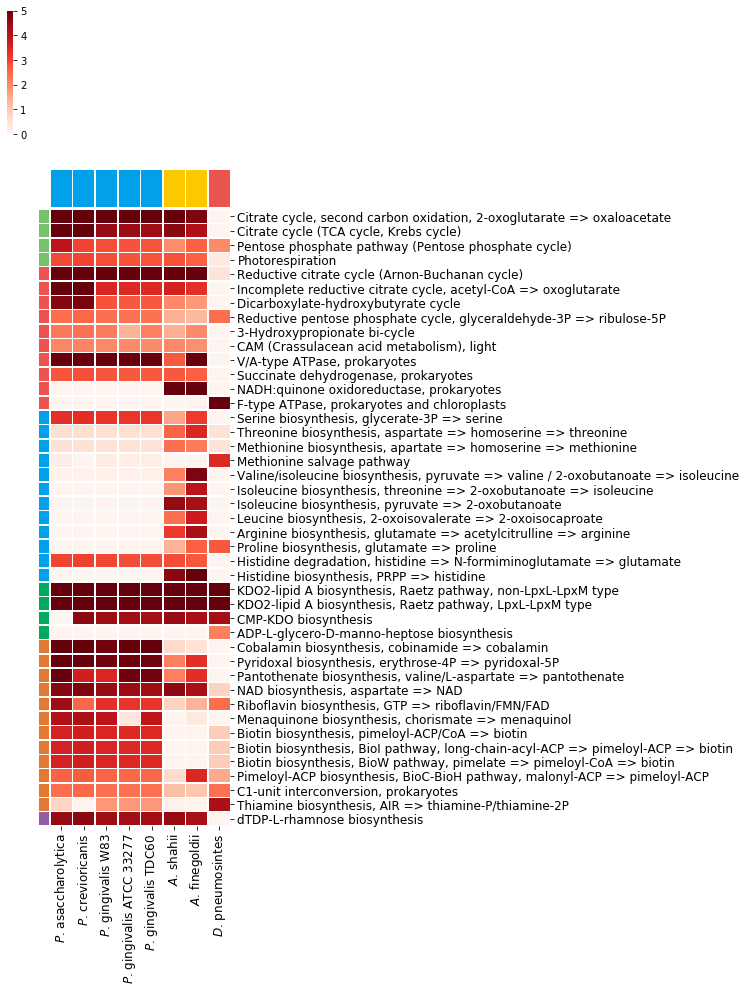

In [902]:
hearmap_data = sort_res[[s+'_-log_fdr' for s in species]]
hearmap_data.shape

col_colors = ['#00a1e9', '#00a1e9', '#00a1e9', '#00a1e9', '#00a1e9', '#fcc800', '#fcc800', '#ea5550']
colors = {'Carbohydrate metabolism':'#79c06e', 'Energy metabolism':'#ea5550', 'Lipid metabolism':'#fcc800',
         'Nucleotide metabolism':'#ffdc00', 'Amino acid metabolism':'#00a1e9', 'Glycan metabolism':'#00a960',
         'Metabolism of cofactors and vitamins': '#e17b34', 'Biosynthesis of terpenoids and polyketides':'#915da3'}
row_colors = [colors[i] for i in sort_res['Path_l1']]
mask = sort_res[[s+'_-log_fdr' for s in species]]<=-np.log10(0.01)
g = sns.clustermap(hearmap_data, mask=None, cmap="Reds", vmin=0, vmax=5, row_cluster=False, col_cluster=False,
                   col_colors=col_colors, row_colors=row_colors, figsize=(4, 15), linewidths=0.5, )
_ = g.ax_heatmap.axes.set_yticklabels(sort_res['MD_Name'], fontsize=12)
_ = g.ax_heatmap.axes.set_xticklabels(['$P$. asaccharolytica', '$P$. crevioricanis',
                                      '$P$. gingivalis W83', '$P$. gingivalis ATCC 33277',
                                      '$P$. gingivalis TDC60', '$A$. shahii',
                                       '$A$. finegoldii', '$D$. pneumosintes'], fontsize=12)

# 相关

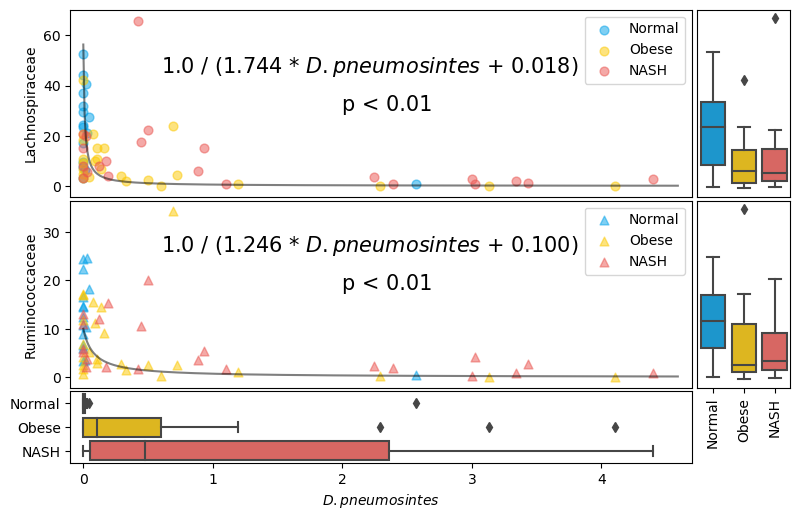

In [27]:
#D. pneumosintes vs. Lachnospiraceae and Ruminococcaceae

L_OTUs = []
R_OTUs = []
for i in abun_df.columns:
    if tax_species.loc[i, 'Family'] == 'Lachnospiraceae':
        L_OTUs.append(i)
    if tax_species.loc[i, 'Family'] == 'Ruminococcaceae':
        R_OTUs.append(i)
#len(L_OTUs), len(R_OTUs)

D_OTU = 'c84919371da9c309c2b7a50ab6ed836c0c9555e6'
L_sum = abun_df.loc[:, L_OTUs].sum(1)
R_sum = abun_df.loc[:, R_OTUs].sum(1)
D_abun = abun_df.loc[:, D_OTU]

import statsmodels.api as sm
X = np.array(D_abun).T
X = sm.add_constant(X)
model = sm.OLS(1.0/L_sum, X)
#results = model.fit()
#results.params
#results.summary()

model = sm.OLS(1.0/R_sum, X)
#results = model.fit()
#results.params
#results.summary()

f_L = lambda x:1.0/(1.744433*x + 0.017732)
f_R = lambda x:1.0/(1.245988*x + 0.099849)

_ = plt.figure(figsize=(8, 6), dpi=100)
gs = gridspec.GridSpec(3, 2, height_ratios=[0.42, 0.42, 0.16], width_ratios=[0.87, 0.13])
gs.update(left=0.05, right=0.95, wspace=0.015, hspace=0.025)
color = {'Normal':'#00a1e9', 'Obese':'#fcc800', 'NASH':'#ea5550'}

ax = plt.subplot(gs[0, 0])
for d in ['Normal', 'Obese', 'NASH']:
    _ = plt.scatter(np.array(D_abun)[DiseaseStatus==d], np.array(L_sum)[DiseaseStatus==d], marker='o',
                    alpha=0.5, s=40, color=color[d], label=d)
_ = plt.legend()
_ = plt.plot(np.arange(0, 4.6, 0.01), [f_L(i) for i in np.arange(0, 4.6, 0.01)], alpha=0.5, color='k')

_ = plt.annotate('1.0 / (1.744 * $D. pneumosintes$ + 0.018)',xy=(0.6, 45), fontsize=15)
_ = plt.annotate('p < 0.01',xy=(2, 30), fontsize=15)

_ = plt.ylabel('Lachnospiraceae')
_ = plt.xlim([-0.1, 4.7])
_ = plt.xticks([])

ax = plt.subplot(gs[0, 1])
plot_data = pd.DataFrame({'State':DiseaseStatus, 'Lachnospiraceae':L_sum})
subplot = sns.boxplot(x="State", y="Lachnospiraceae", data=plot_data, palette=['#00a1e9', '#fcc800', '#ea5550'],
                order=['Normal', 'Obese', 'NASH'])
_ = subplot.set_xticks([])
_ = subplot.set_yticks([])
_ = subplot.set_ylabel('')
_ = subplot.set_xlabel('')

ax = plt.subplot(gs[1, 0])
for d in ['Normal', 'Obese', 'NASH']:
    _ = plt.scatter(np.array(D_abun)[DiseaseStatus==d], np.array(R_sum)[DiseaseStatus==d], marker='^',
                    alpha=0.5, s=40, color=color[d], label=d)
_ = plt.legend()
_ = plt.plot(np.arange(0, 4.6, 0.01), [f_R(i) for i in np.arange(0, 4.6, 0.01)], alpha=0.5, color='k')

_ = plt.annotate('1.0 / (1.246 * $D. pneumosintes$ + 0.100)',xy=(0.6, 26), fontsize=15)
_ = plt.annotate('p < 0.01',xy=(2, 18), fontsize=15)

_ = plt.ylabel('Ruminococcaceae')
_ = plt.xlim([-0.1, 4.7])
_ = plt.xticks([])

ax = plt.subplot(gs[1, 1])
plot_data = pd.DataFrame({'State':DiseaseStatus, 'Ruminococcaceae':R_sum})
subplot = sns.boxplot(x="State", y="Ruminococcaceae", data=plot_data, palette=['#00a1e9', '#fcc800', '#ea5550'],
                order=['Normal', 'Obese', 'NASH'])
_ = subplot.set_xticks([0, 1, 2])
_ = subplot.set_xticklabels(['Normal', 'Obese', 'NASH'], rotation=90)
_ = subplot.set_yticks([])
_ = subplot.set_ylabel('')
_ = subplot.set_xlabel('')

ax = plt.subplot(gs[2, 0])
plot_data = pd.DataFrame({'State':DiseaseStatus, 'D. pneumosintes':D_abun})
subplot = sns.boxplot(x="D. pneumosintes", y="State", data=plot_data, palette=['#00a1e9', '#fcc800', '#ea5550'],
                order=['Normal', 'Obese', 'NASH'], orient='h')
_ = subplot.set_yticks([0, 1, 2])
_ = subplot.set_yticklabels(['Normal', 'Obese', 'NASH'], rotation=0)
_ = subplot.set_ylabel('')
_ = subplot.set_xlabel('$D. pneumosintes$')
_ = plt.xlim([-0.1, 4.7])
_ = plt.ylim([2.5, -0.5])

_ = plt.show()
